In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
from shapely.geometry import Point
import math
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
plt.rcParams['figure.dpi'] = 450

In [4]:
trips_raw = pd.read_csv('trips_raw_data.csv')

/Users/Rick/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (11,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
trips_raw.head()

,Unnamed: 0,Trip Id,Subscription Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,...,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather
0,58,712441,NaN,274,7006.0,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
1,59,712442,NaN,538,7046.0,2017-01-01 00:03:00-05:00,Niagara St / Richmond St W,7147.0,2017-01-01 00:12:00-05:00,King St W / Fraser Ave,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
2,60,712443,NaN,992,7048.0,2017-01-01 00:05:00-05:00,Front St W / Yonge St (Hockey Hall of Fame),7089.0,2017-01-01 00:22:00-05:00,Church St / Wood St,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
3,61,712444,NaN,1005,7177.0,2017-01-01 00:09:00-05:00,East Liberty St / Pirandello St,7202.0,2017-01-01 00:26:00-05:00,Queen St W / York St (City Hall),...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
4,62,712445,NaN,645,7203.0,2017-01-01 00:14:00-05:00,Bathurst St/Queens Quay(Billy Bishop Airport),7010.0,2017-01-01 00:25:00-05:00,King St W / Spadina Ave,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN


# Bike Share Trips Origin and Destination

Lets see which neighbourhoods have the highest departures and arrivals from the bike share data.

## Merging Datasets

First, lets use the Neighbourhoods file from the City of Toronto Open Data. The City has 140 designated neighbourhoods, and they are composed of a couple census tracts.

We're using the geojson version since that is easier to work with than managing multiple files needed for the a shapefile.

In [6]:
neighbourhoods = gpd.read_file('Neighbourhoods.geojson')
neighbourhoods.head(5)

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,CLASSIFICATION,CLASSIFICATION_CODE,geometry
0,11201,2480141,26005521,None,96,96,Casa Loma (96),Casa Loma (96),None,None,None,None,17545105,3.678385e+06,8214.176485,None,None,"POLYGON ((-79.41469 43.67391, -79.41485 43.674..."
1,11202,2480140,26005520,None,95,95,Annex (95),Annex (95),None,None,None,None,17545121,5.337192e+06,10513.883143,None,None,"POLYGON ((-79.39414 43.66872, -79.39588 43.668..."
2,11203,2480139,26005519,None,109,109,Caledonia-Fairbank (109),Caledonia-Fairbank (109),None,None,None,None,17545137,2.955857e+06,6849.911724,None,None,"POLYGON ((-79.46021 43.68156, -79.46044 43.681..."
3,11204,2480064,26005444,None,64,64,Woodbine Corridor (64),Woodbine Corridor (64),None,None,None,None,17545153,3.052518e+06,7512.966773,None,None,"POLYGON ((-79.31485 43.66674, -79.31660 43.666..."
4,11205,2480063,26005443,None,103,103,Lawrence Park South (103),Lawrence Park South (103),None,None,None,None,17545169,6.211341e+06,13530.370002,None,None,"POLYGON ((-79.41096 43.70408, -79.41165 43.703..."


In this step, I'll rename some columns, and remove the neighbourhood id from the name string using some regex commands. We basically are removing cases where there are 1, 2, or 3 numerical digits from the string. 

We'll still keep the the neighbourhood id, as its better to use that as our unique identifier.

In [7]:
neighbourhoods = neighbourhoods.rename(columns = {'AREA_NAME':'name', 'AREA_SHORT_CODE':'area_short'})

neighbourhoods['name'] = neighbourhoods['name'].str.replace(' \(\d\d\)', '').str.replace(' \(\d\d\d\)', '').str.replace(' \(\d\)', '')
neighbourhoods = neighbourhoods[['area_short','name', 'geometry']]

/Users/Rick/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In a spreadsheet, I went ahead and manually classified each neighbourhood into a higher level of geography. I'm using the [pre-1998 Metro Toronto Borough/City boundaries](https://en.wikipedia.org/wiki/Amalgamation_of_Toronto) to classify neighbourhoods into North York, Scarborough, York, East York, and Etobicoke. This process was easy, since neighbourhood boundaries (and census tracts) line up with the former Metro Toronto boundaries, and the `area_short` parameter is numerically grouped into the former cities/boroughs.

I further subdivided neighbourhoods located in the former Old Toronto. For Downtown, I used the [TOcore](https://www.toronto.ca/city-government/planning-development/planning-studies-initiatives/tocore-planning-torontos-downtown/tocore-overview/) definition of Downtown. From their, the East End is everything east of the Don River, the West End is generally west of Bathurst, and the North End is generally everything north of Bloor Street. The Annex, and Wychwoods neighbourhoods were placed in the North End, and those neighbourhoods formed the boundary between the North and West ends.

In [8]:
neighbourhoods = neighbourhoods.merge(pd.read_csv('neighbourhood_groupings.csv'))
neighbourhoods.head()

,area_short,name,geometry,Borough
0,96,Casa Loma,"POLYGON ((-79.41469 43.67391, -79.41485 43.674...",North End
1,95,Annex,"POLYGON ((-79.39414 43.66872, -79.39588 43.668...",North End
2,109,Caledonia-Fairbank,"POLYGON ((-79.46021 43.68156, -79.46044 43.681...",York
3,64,Woodbine Corridor,"POLYGON ((-79.31485 43.66674, -79.31660 43.666...",East End
4,103,Lawrence Park South,"POLYGON ((-79.41096 43.70408, -79.41165 43.703...",North End


To make the maps look more recognizable to the average person, and for easy distance calculations, we're going to use a mercator projection. `EPSG = 26917` corresponds to UTM zone 17N, which is the associated zone for Toronto.

In [9]:
neighbourhoods = neighbourhoods.to_crs(epsg = '26917')

We'll also rotate our geography 17 degrees, so that Yonge Street is a vertical line. This also makes it easier to read, and this decision is frequently used in official city publications, such as TTC maps, or official City of Toronto Maps.

In [10]:
for index, row in neighbourhoods.iterrows():
    rotated = shapely.affinity.rotate(row['geometry'], angle=-17, origin = Point(0, 0))
    neighbourhoods.at[index, 'geometry'] = rotated

Let's make a quick map of our borough groupings. I'll use the `dissolve` method for GeoDataFrames to group neighbourhoods by boroughs and dissolve their borders.

In [11]:
boroughs = neighbourhoods.dissolve(by = 'Borough')
city_boundary = gpd.geoseries.GeoSeries([neighbourhoods.unary_union]) # to create a single polygon representing Toronto

I'm going to create a centroid column. This will make it easier to plot labels, as the labels will be over the centroid.

In [12]:
boroughs['centroid'] = boroughs['geometry'].apply(lambda x: x.centroid.coords[:])
boroughs['centroid'] = [i[0] for i in boroughs['centroid']]
boroughs = boroughs.reset_index()

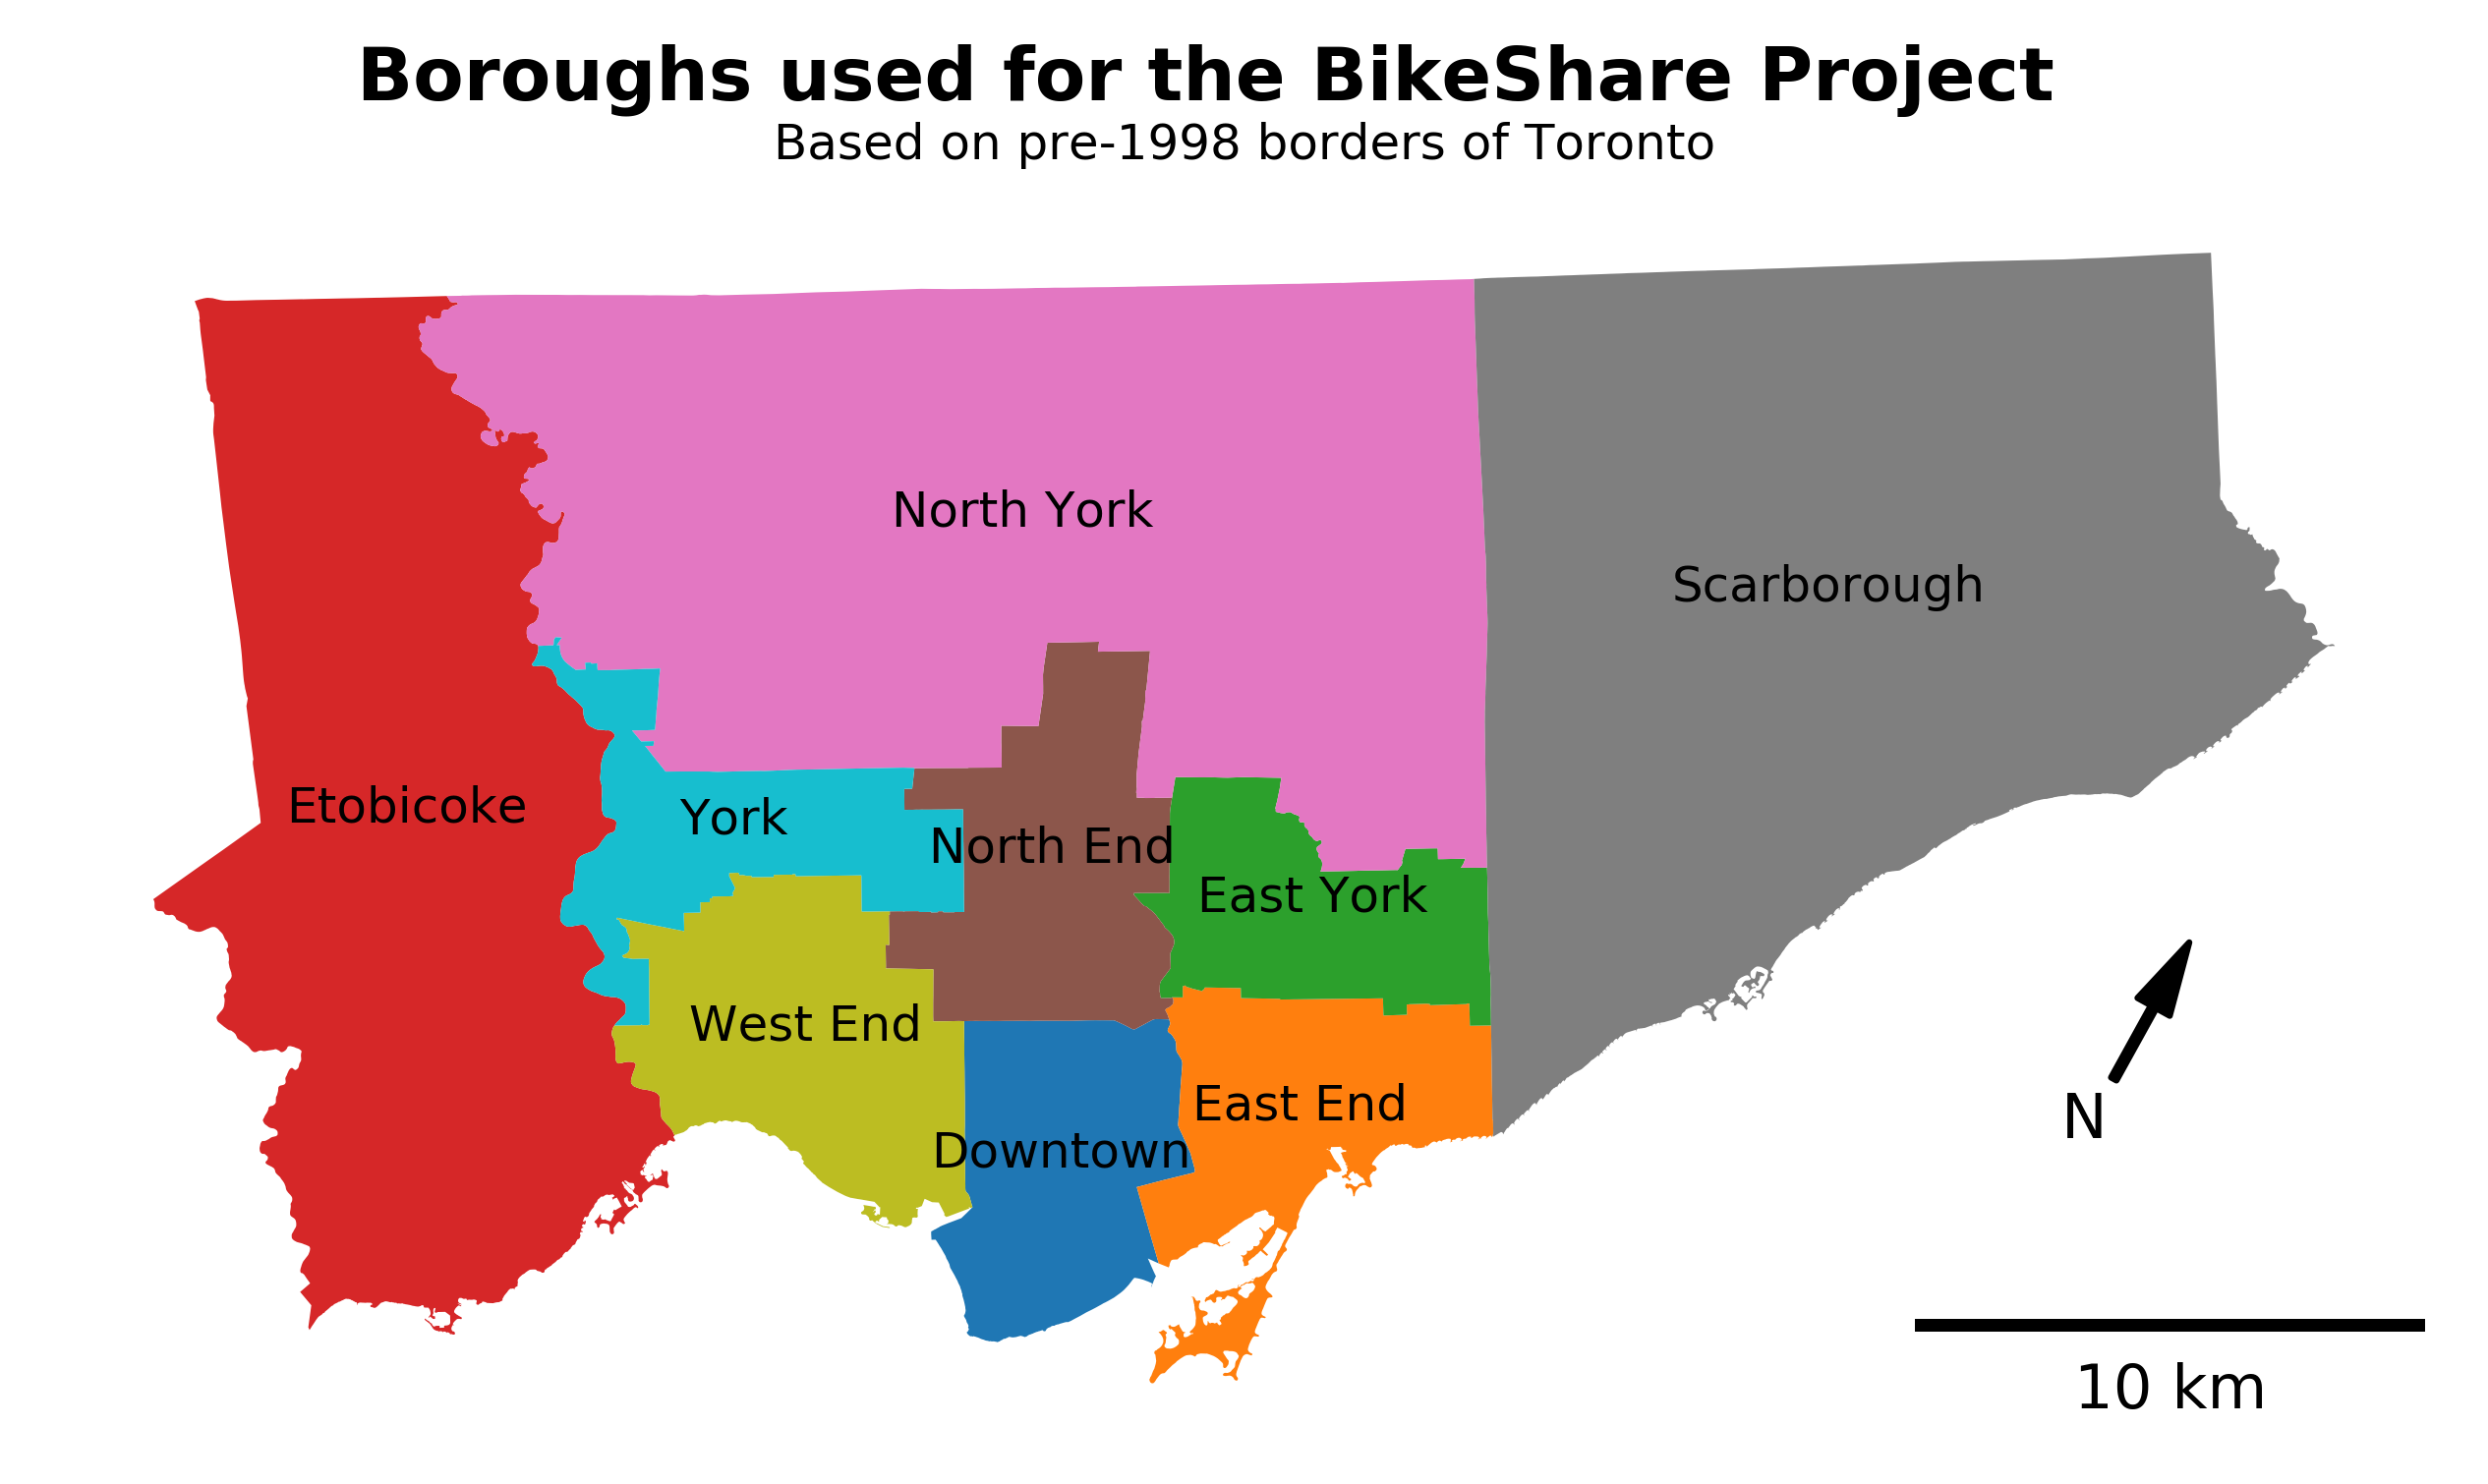

In [13]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredDirectionArrows # for north arrow

fig, ax = plt.subplots()
fig.set_size_inches(7,4)

boroughs.plot(cmap = 'tab10', ax = ax)

#north arrow
x, y, arrow_length = 0.85, 0.4, 0.15
ax.annotate('N', xy=(x + 0.15 * math.sin(math.radians(17)), y), xytext=(x, y- 0.15 * math.cos(math.radians(17))),
            arrowprops = dict(facecolor='black', width=1, headwidth=6),
            ha='center', va='center', fontsize=10,
            xycoords=ax.transAxes)


plt.suptitle('Boroughs used for the BikeShare Project', fontsize = 12, fontweight = 'bold', y = 0.94)
ax.set_title('Based on pre-1998 borders of Toronto', fontsize = 8)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_axis_off()

ax.add_artist(ScaleBar(1, location = 'lower right', length_fraction = 0.25)) # scalebar

for index, row in boroughs.iterrows(): #iteratively plots labels
    plt.annotate(s=row['Borough'], xy=row['centroid'], ha = 'center', fontsize = 8)

Now lets join the bikeshare stations locations to a neighbourhood and borough.

In [14]:
stations = pd.read_csv('bikeshare_stations.csv')

First we need to create a GeoDataFrame using the `lat` and `lon` found in the csv. Then we need to convert it to a UTM projection and rotate the geometry by 17 degrees.

In [15]:
stations_gdf = gpd.GeoDataFrame(stations, geometry = 
                                          gpd.points_from_xy(stations.lon, stations.lat)).set_crs(epsg = '4326').to_crs(epsg = '26917')

for index, row in stations_gdf.iterrows():
    rotated = shapely.affinity.rotate(row['geometry'], angle=-17, origin = Point(0, 0))
    stations_gdf.at[index, 'geometry'] = rotated

To spatially join the datasets, we'll use Geopandas' `sjoin` function to return which neighbourhood a bike share station is in.

In [16]:
stations_gdf = gpd.sjoin(neighbourhoods, stations_gdf)

## Analyzing Trip Origins

First, let's count the number of departures by start stations. To reduce the complexity of the data, we can avoid drop the other columns. We'll name the count column as `Trips`.

In [17]:
trips_origin = trips_raw.groupby('Start Station Id').count()[['Trip Id']]

In [18]:
trips_origin = trips_origin.reset_index()

In [19]:
trips_origin = trips_origin.rename(columns = {'Trip Id': 'Trips'})

In [20]:
trips_origin.head()

,Start Station Id,Trips
0,7000.0,54238
1,7001.0,28795
2,7002.0,42372
3,7003.0,26537
4,7004.0,23452


We'll use left join the dataset to the lookup table with the neighbourhoods and station Ids. Here we're doing two left joins, one with the GeoDataFrame of the stations, then with the GeoDataFrame of the neighbourhoods to make sure that when we plot the data, it will plot the neighbourhoods. 

Then, we need to do another groupby aggregation (using the `sum` function) to sum up the trip origins by neighbourhood.

In [21]:
trips_origin_gdf = stations_gdf.merge(trips_origin, right_on = 'Start Station Id', left_on = 'Station Id', how = 'left')

In [22]:
trips_origin_gdf['Trips'] = trips_origin_gdf['Trips'].fillna(0)

In [23]:
trips_origin_gdf = neighbourhoods.merge(trips_origin_gdf.groupby('area_short').sum()[['Trips']].reset_index(), how = 'left')

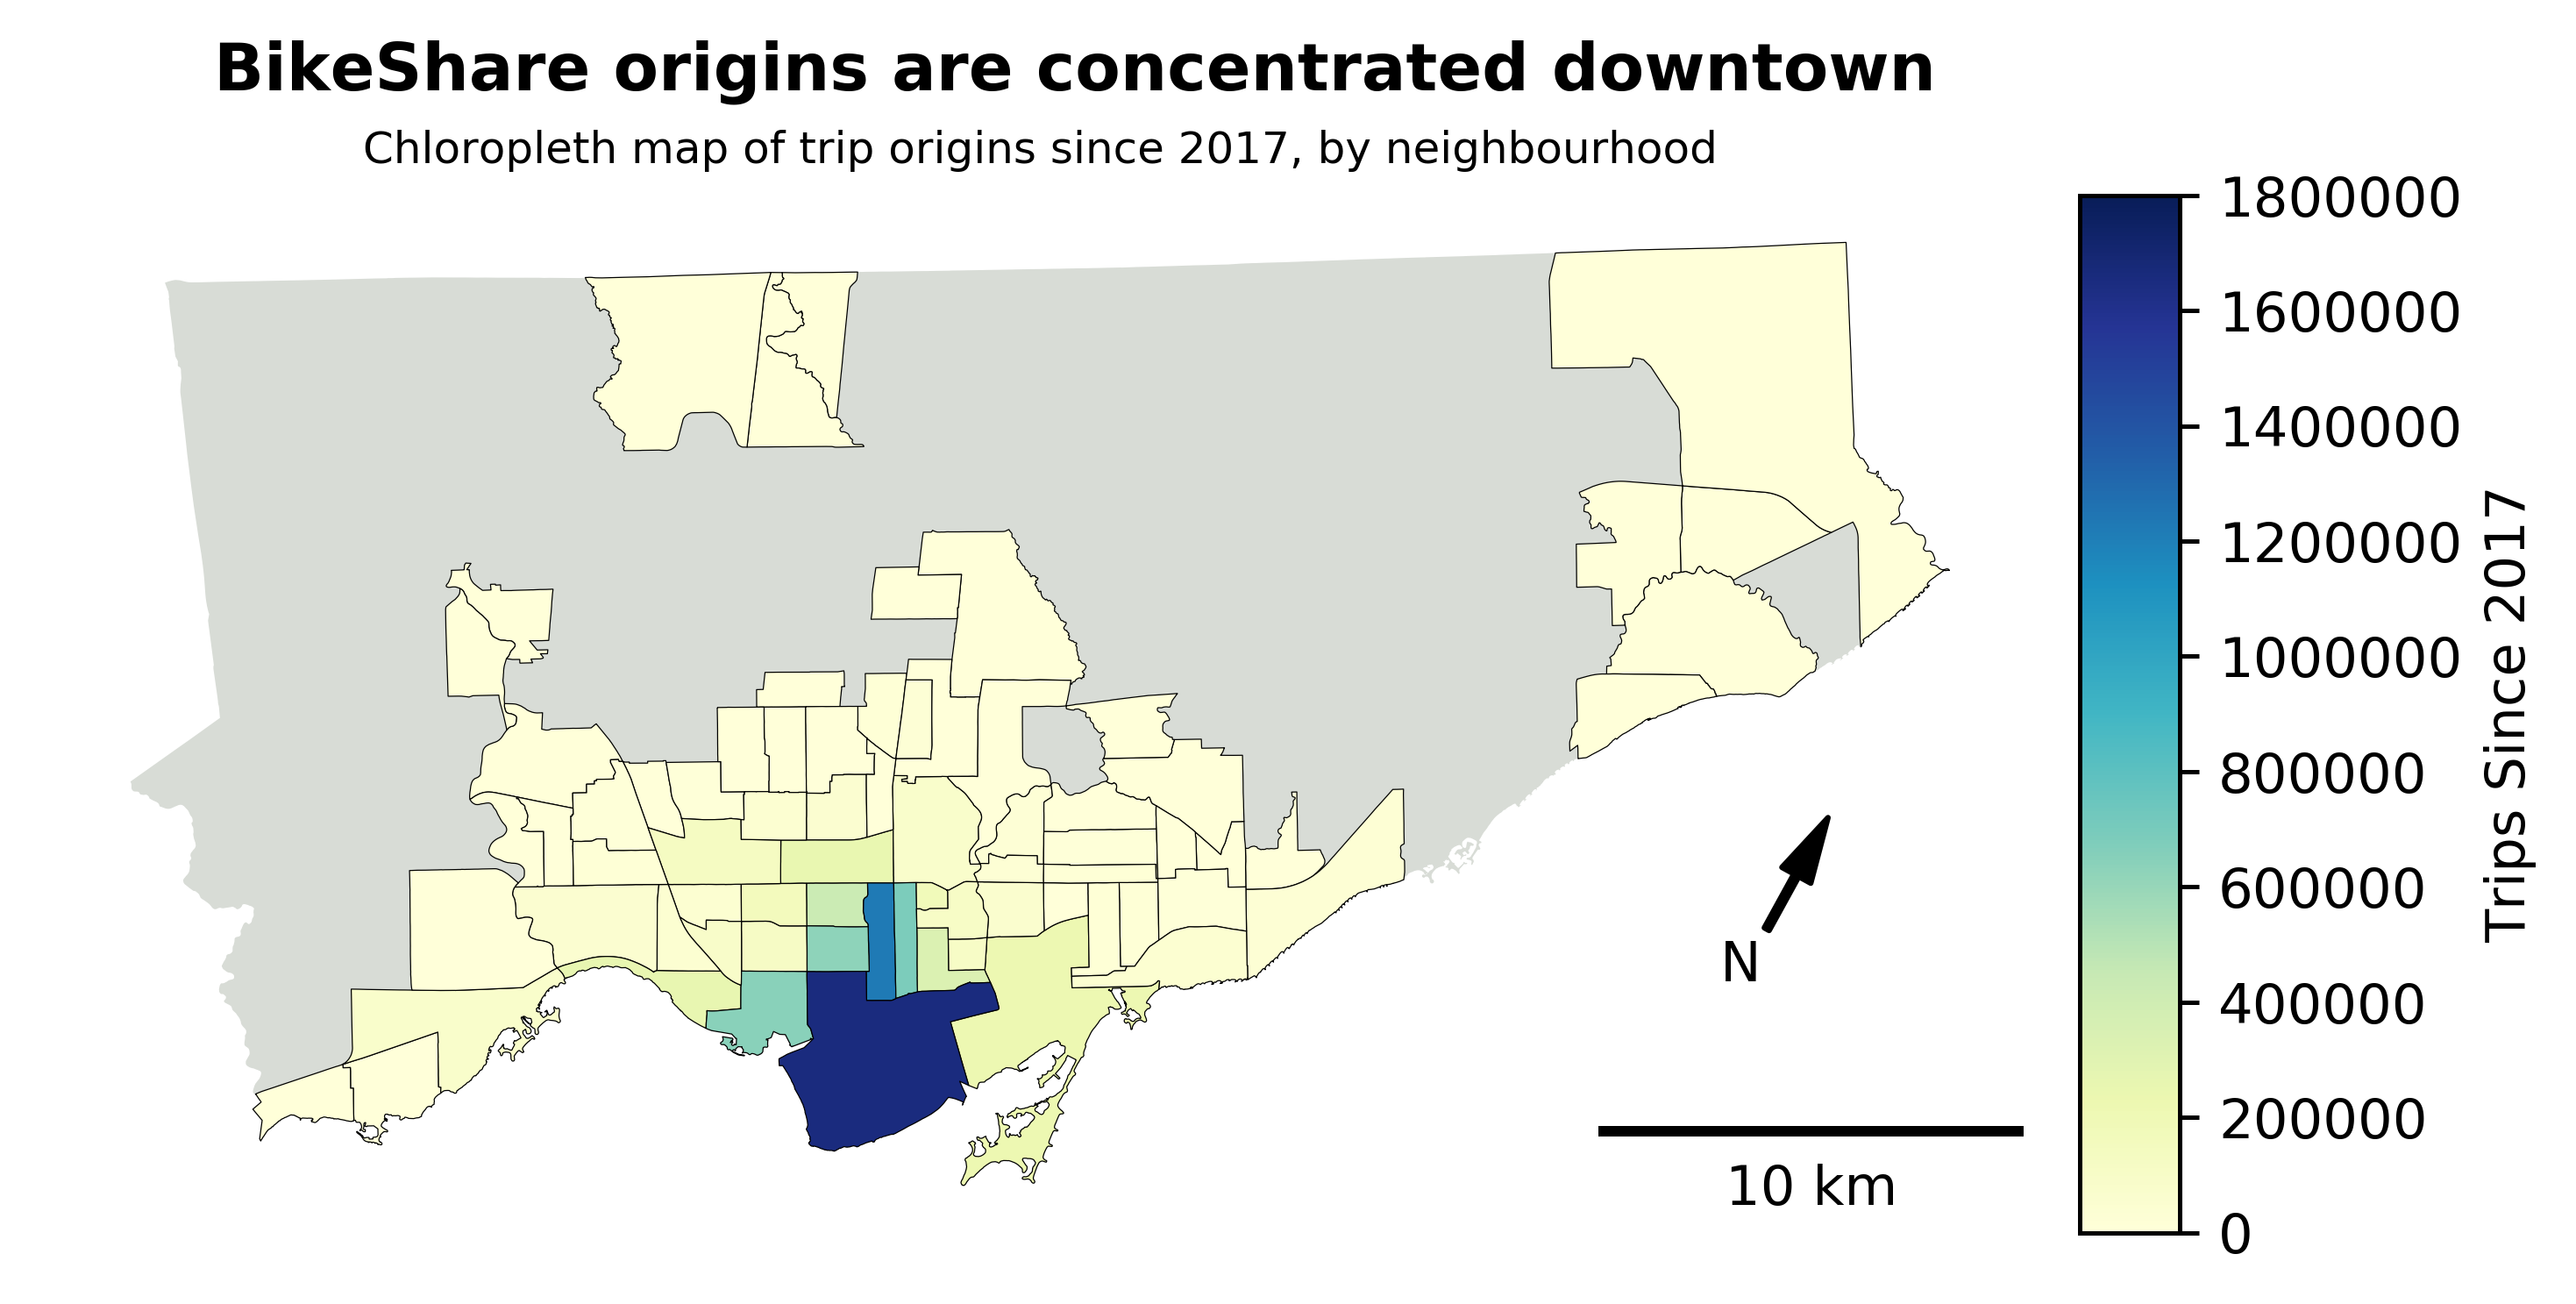

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(7,4)

divider = make_axes_locatable(ax) 

cax = divider.append_axes("right", size="5%", pad=0.1) #to clean up the chloropleth legend

trips_origin_gdf.plot(column = 'Trips', cmap = 'YlGnBu', ax = ax, legend = True, 
                      zorder = 1, edgecolor = 'k', linewidth = 0.2,
                     legend_kwds={'label': "Trips Since 2017"}, cax = cax, vmin = 0, vmax = 1800000)

city_boundary.plot(ax = ax, zorder = 0, color = 'xkcd:light grey') #any neighbourhood without a bike share trip will be grey

#north arrow
x, y, arrow_length = 0.85, 0.4, 0.15
ax.annotate('N', xy=(x + 0.15 * math.sin(math.radians(17)), y), xytext=(x, y- 0.15 * math.cos(math.radians(17))),
            arrowprops = dict(facecolor='black', width=1, headwidth=6),
            ha='center', va='center', fontsize=10,
            xycoords=ax.transAxes)

plt.suptitle('BikeShare origins are concentrated downtown', fontsize = 12, fontweight = 'bold', y = 0.93)

ax.set_title('Chloropleth map of trip origins since 2017, by neighbourhood', fontsize = 8)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_axis_off()

ax.add_artist(ScaleBar(1, location = 'lower right', length_fraction = 0.25))# scale bar

The data shows that the trips are strongly concentrated downtown. Outside of downtown, there are some activity in neighbourhoods along the Waterfront, specifically the Martin Goodman Trail (such as South Parkdale, and Humber Bay Shores).

Let's make a bar chart to find out the names of the top 10 neighbourhoods for bikeshare trip origins.

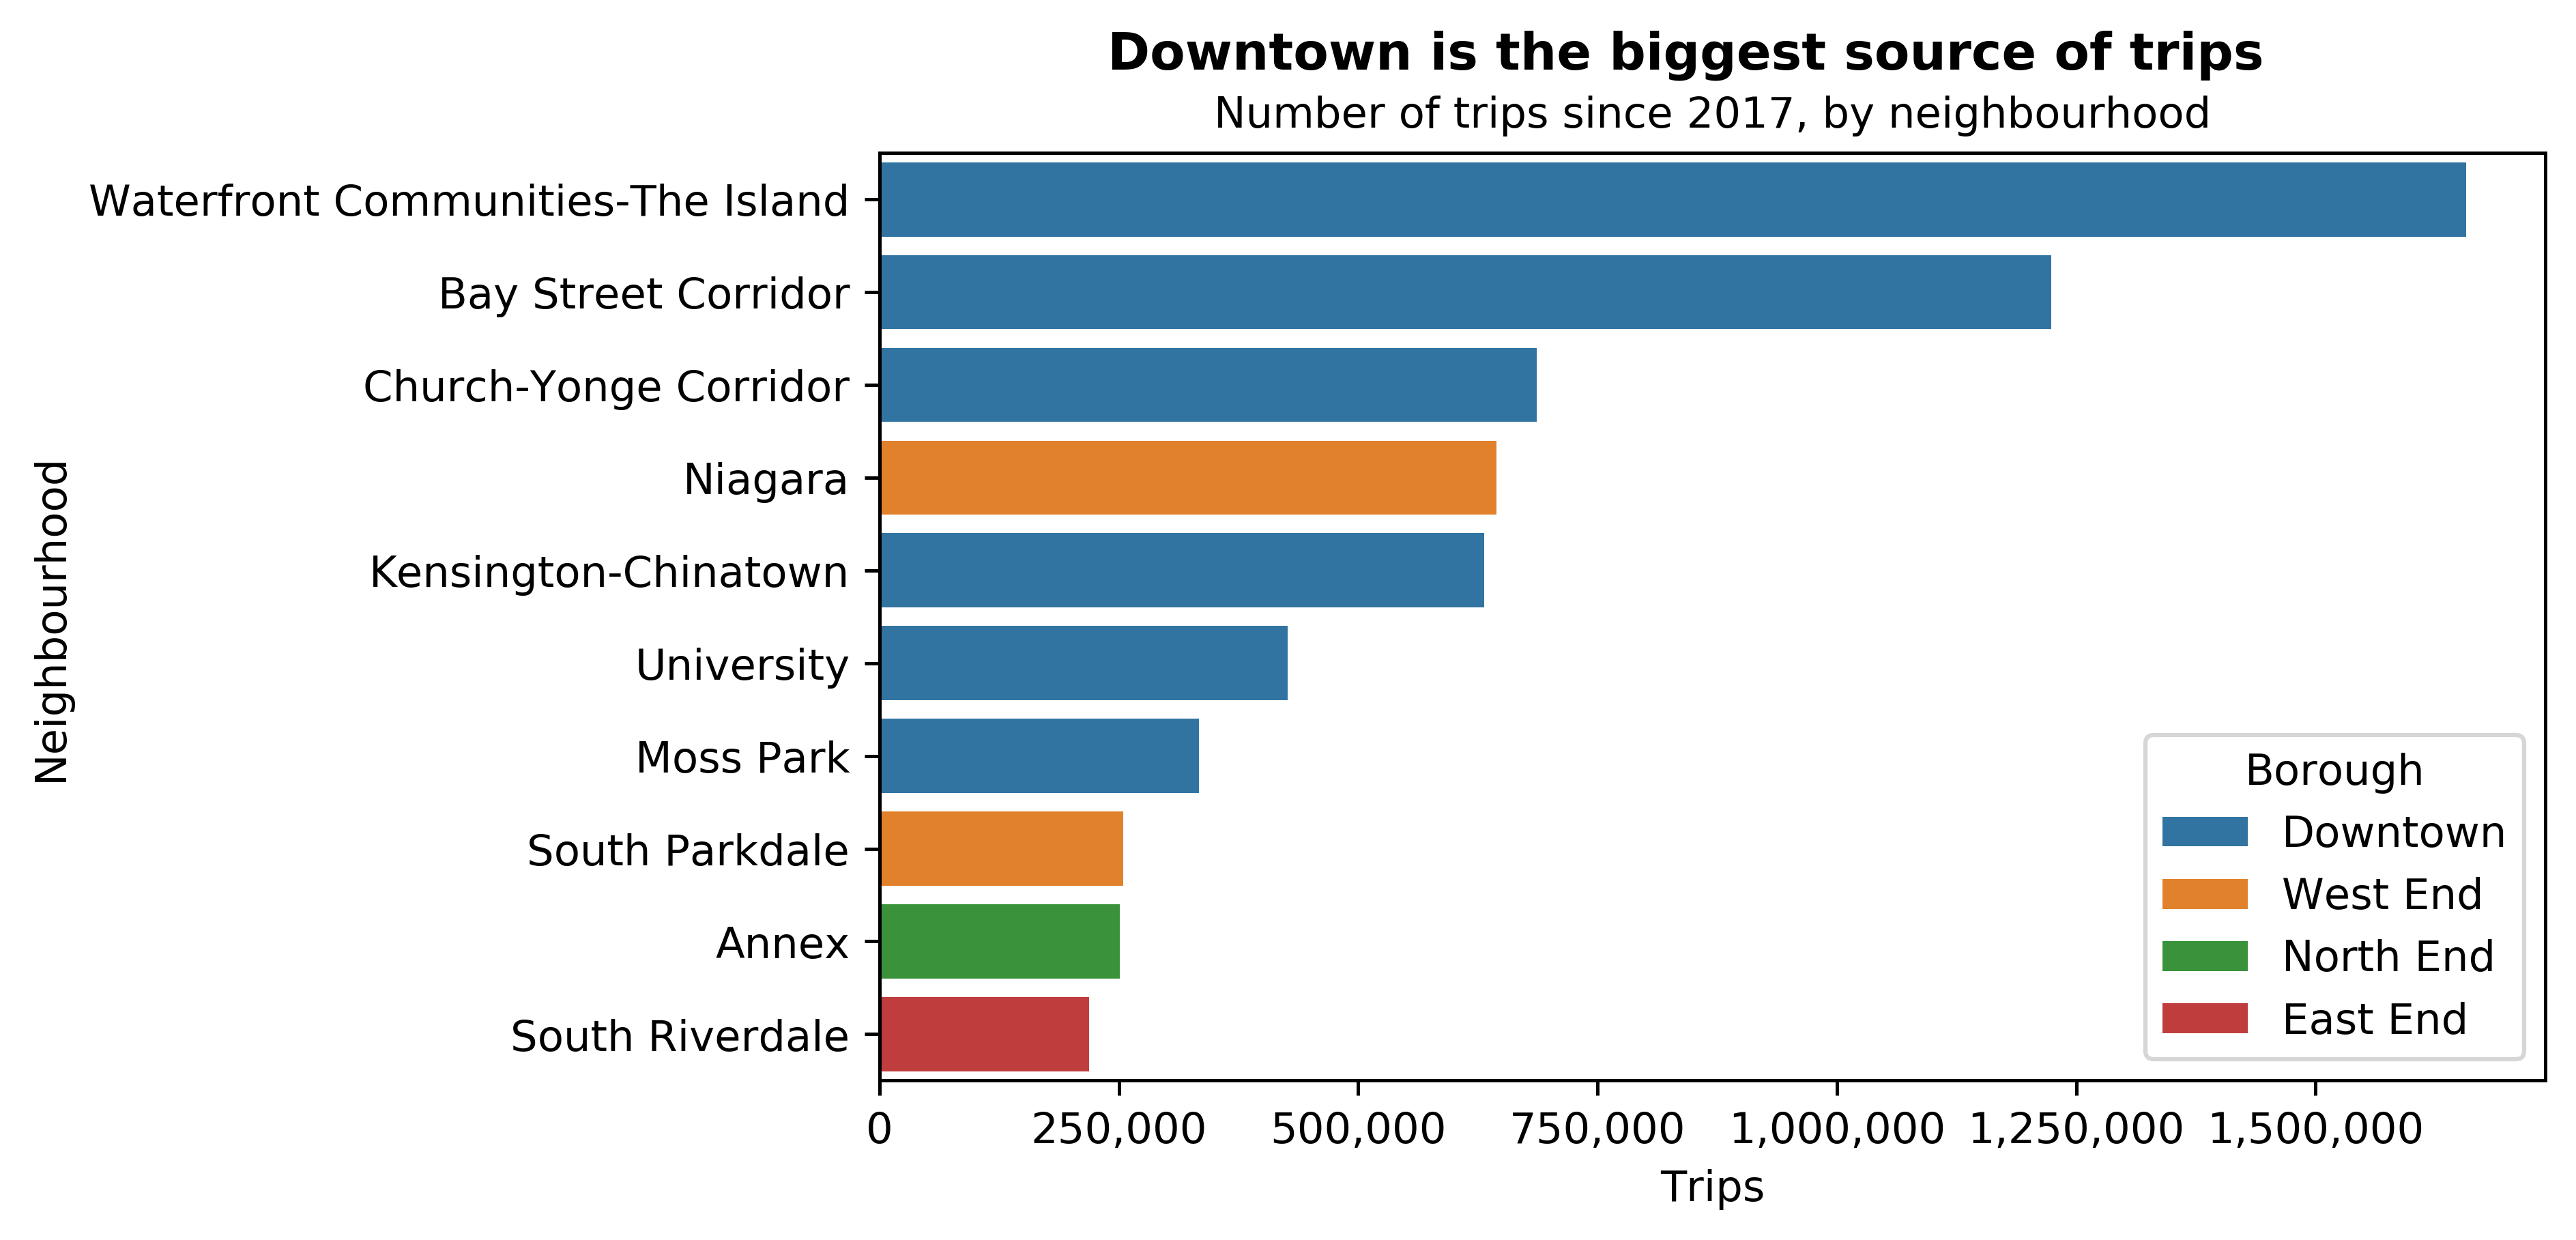

In [25]:
fig, ax = plt.subplots()

fig.set_size_inches(7,4)

top_10_origins = trips_origin_gdf.sort_values(by = 'Trips', ascending = False).head(10)

sns.barplot(y = 'name', x = 'Trips', data = top_10_origins, ax = ax, orient = 'h', hue = 'Borough', dodge = False)

ax.set_yticks(range(10))
ax.set_xticks(range(0,1750000,250000))

ax.set_ylabel('Neighbourhood')
ax.set_xlabel('Trips')

ax.set_title('Number of trips since 2017, by neighbourhood', fontsize = 10)
plt.suptitle('Downtown is the biggest source of trips', fontweight = 'bold', fontsize = 12)

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_yticklabels(top_10_origins['name'])

plt.show()

Again a similar story with the map. The non-downtown neighbourhoods that show up on this list are neighbourhoods that border the lake.

Whats not on this chart are other downtown neighbourhoods, such as St Jamestown, Cabbagetown, and Regent Park. This may suggest that income might play a factor in determining the number of bikeshare trips a neighbourhood has.

## Analyzing Trip Destinations

Now let's repeat all the same steps above, but for trip destinations. This means we'll group by the `End Station Id` before joining.

In [26]:
trips_dest = trips_raw.groupby('End Station Id').count()[['Trip Id']]
trips_dest = trips_dest.reset_index()
trips_dest = trips_dest.rename(columns = {'Trip Id': 'Trips'})

trips_dest_gdf = stations_gdf.merge(trips_dest, right_on = 'End Station Id', left_on = 'Station Id', how = 'left')
trips_dest_gdf = neighbourhoods.merge(trips_dest_gdf.groupby('area_short').sum()[['Trips']].reset_index(), how = 'left')

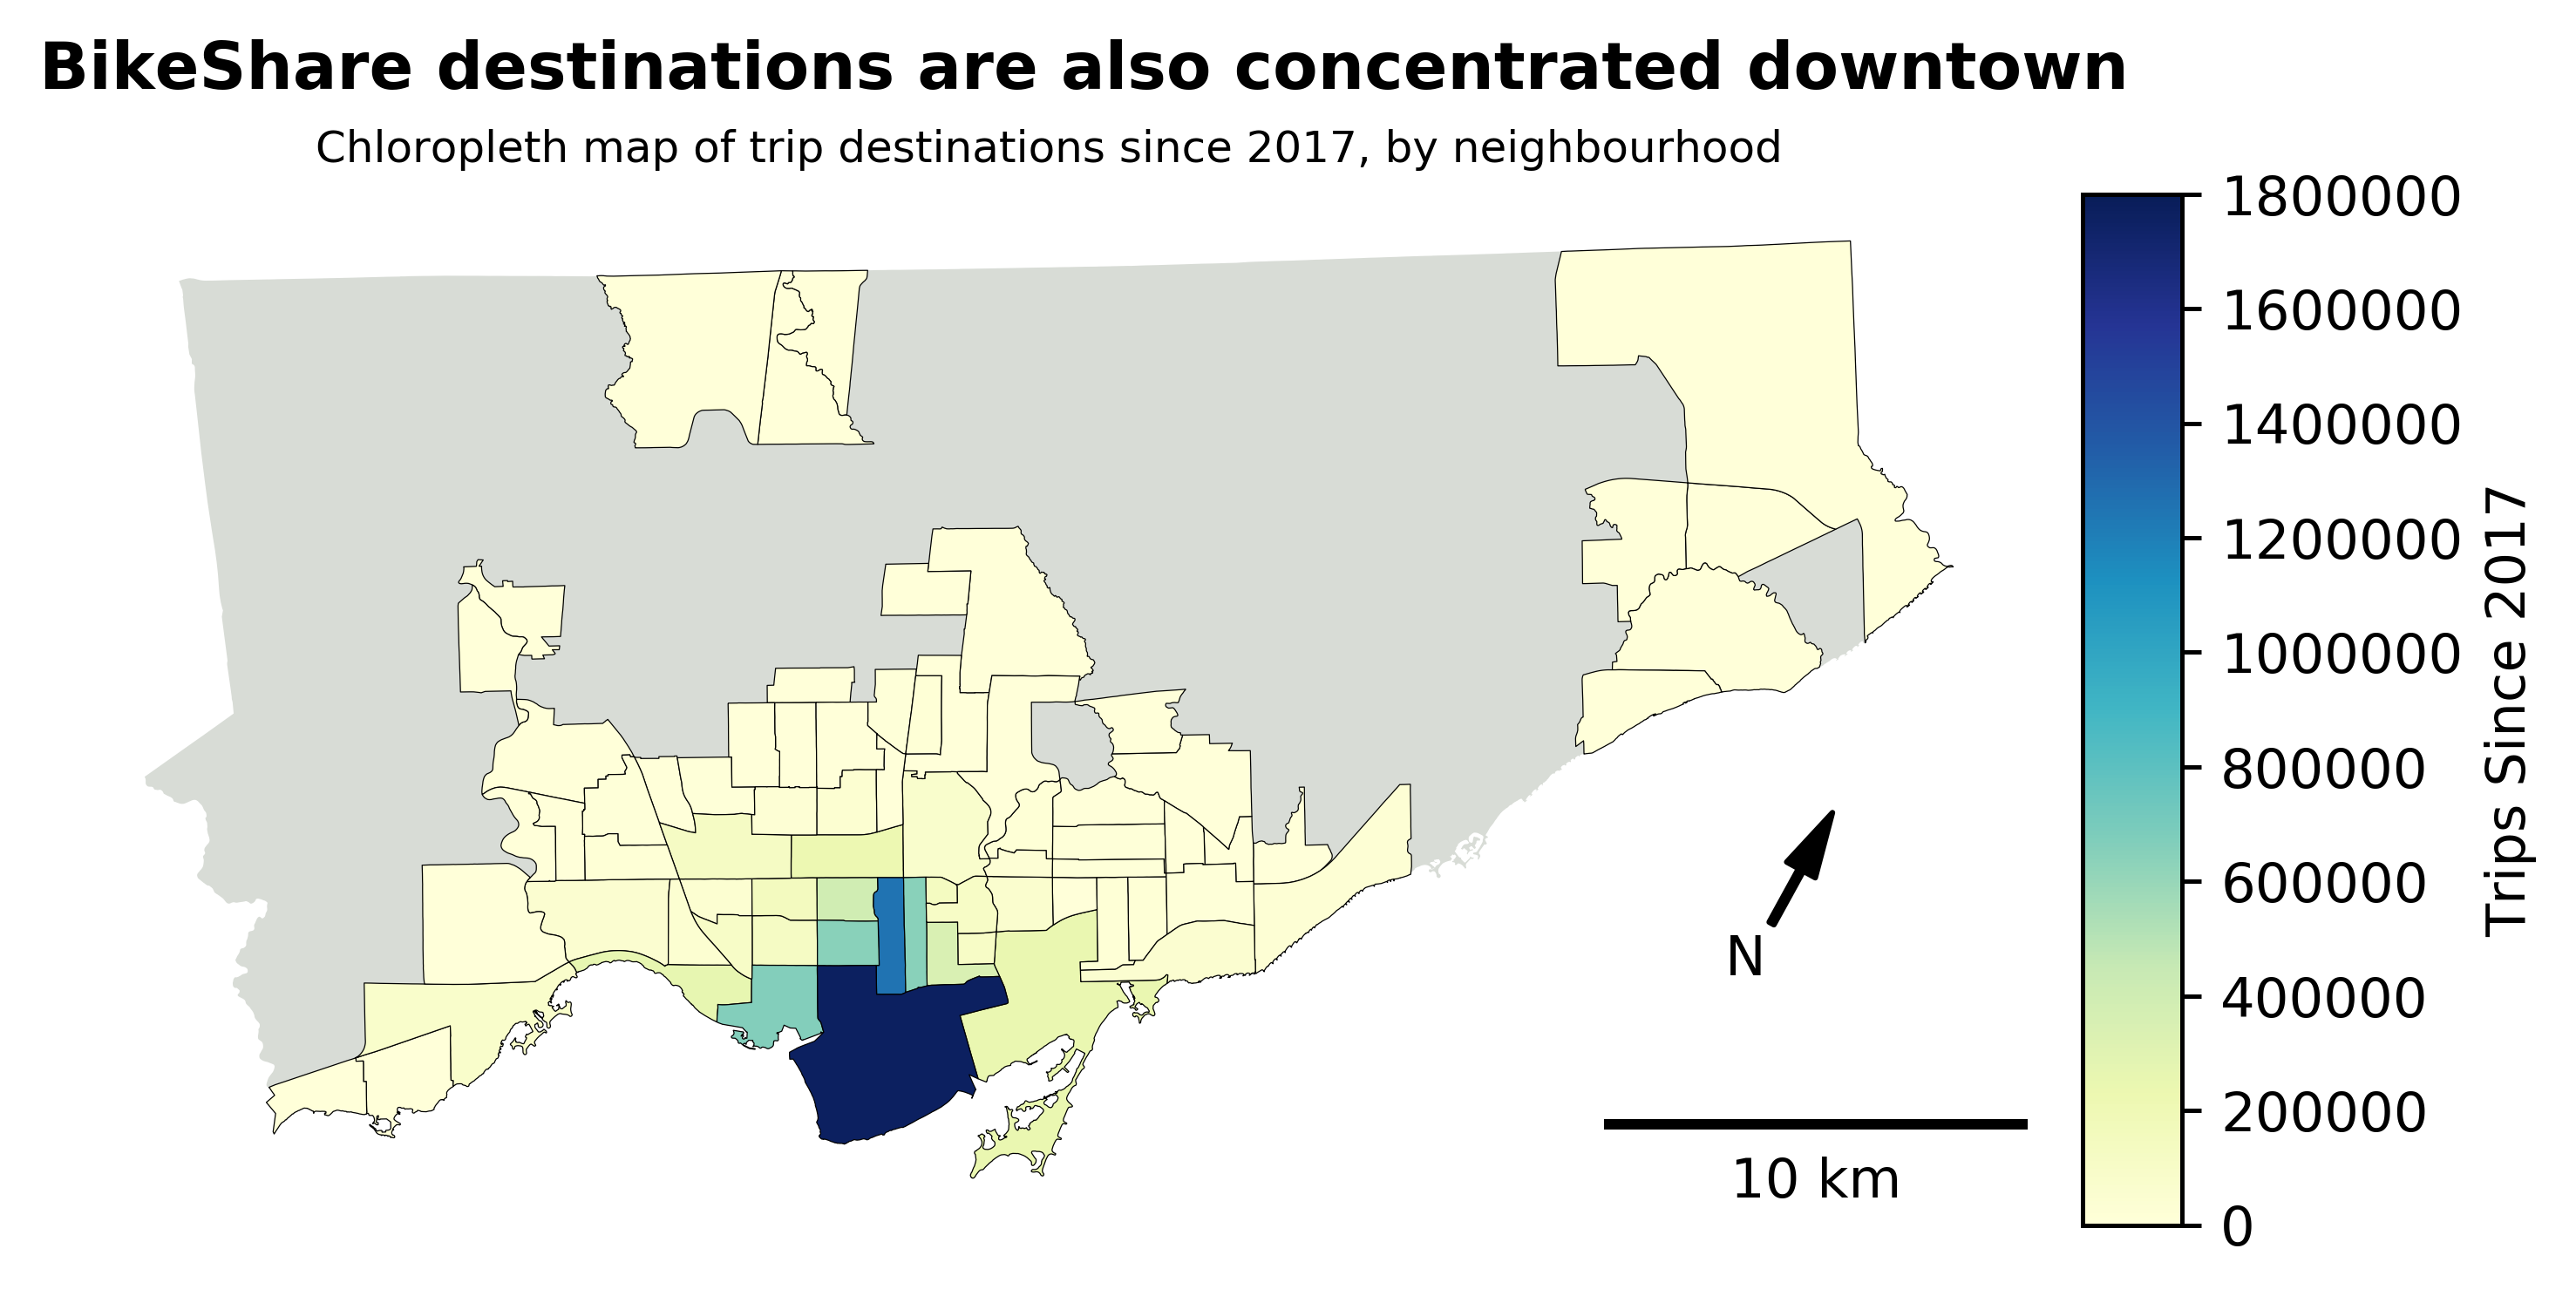

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(7,4)

divider = make_axes_locatable(ax) 

cax = divider.append_axes("right", size="5%", pad=0.1) #to clean up the chloropleth legend

trips_dest_gdf.plot(column = 'Trips', cmap = 'YlGnBu', ax = ax, legend = True, 
                      zorder = 1, edgecolor = 'k', linewidth = 0.2,
                     legend_kwds={'label': "Trips Since 2017"}, cax = cax, vmin = 0, vmax = 1800000)

city_boundary.plot(ax = ax, zorder = 0, color = 'xkcd:light grey') #any neighbourhood without a bike share trip will be grey

#north arrow
x, y, arrow_length = 0.85, 0.4, 0.15
ax.annotate('N', xy=(x + 0.15 * math.sin(math.radians(17)), y), xytext=(x, y- 0.15 * math.cos(math.radians(17))),
            arrowprops = dict(facecolor='black', width=1, headwidth=6),
            ha='center', va='center', fontsize=10,
            xycoords=ax.transAxes)

plt.suptitle('BikeShare destinations are also concentrated downtown', fontsize = 12, fontweight = 'bold', y = 0.93)

ax.set_title('Chloropleth map of trip destinations since 2017, by neighbourhood', fontsize = 8)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_axis_off()

ax.add_artist(ScaleBar(1, location = 'lower right', length_fraction = 0.25))# scale bar

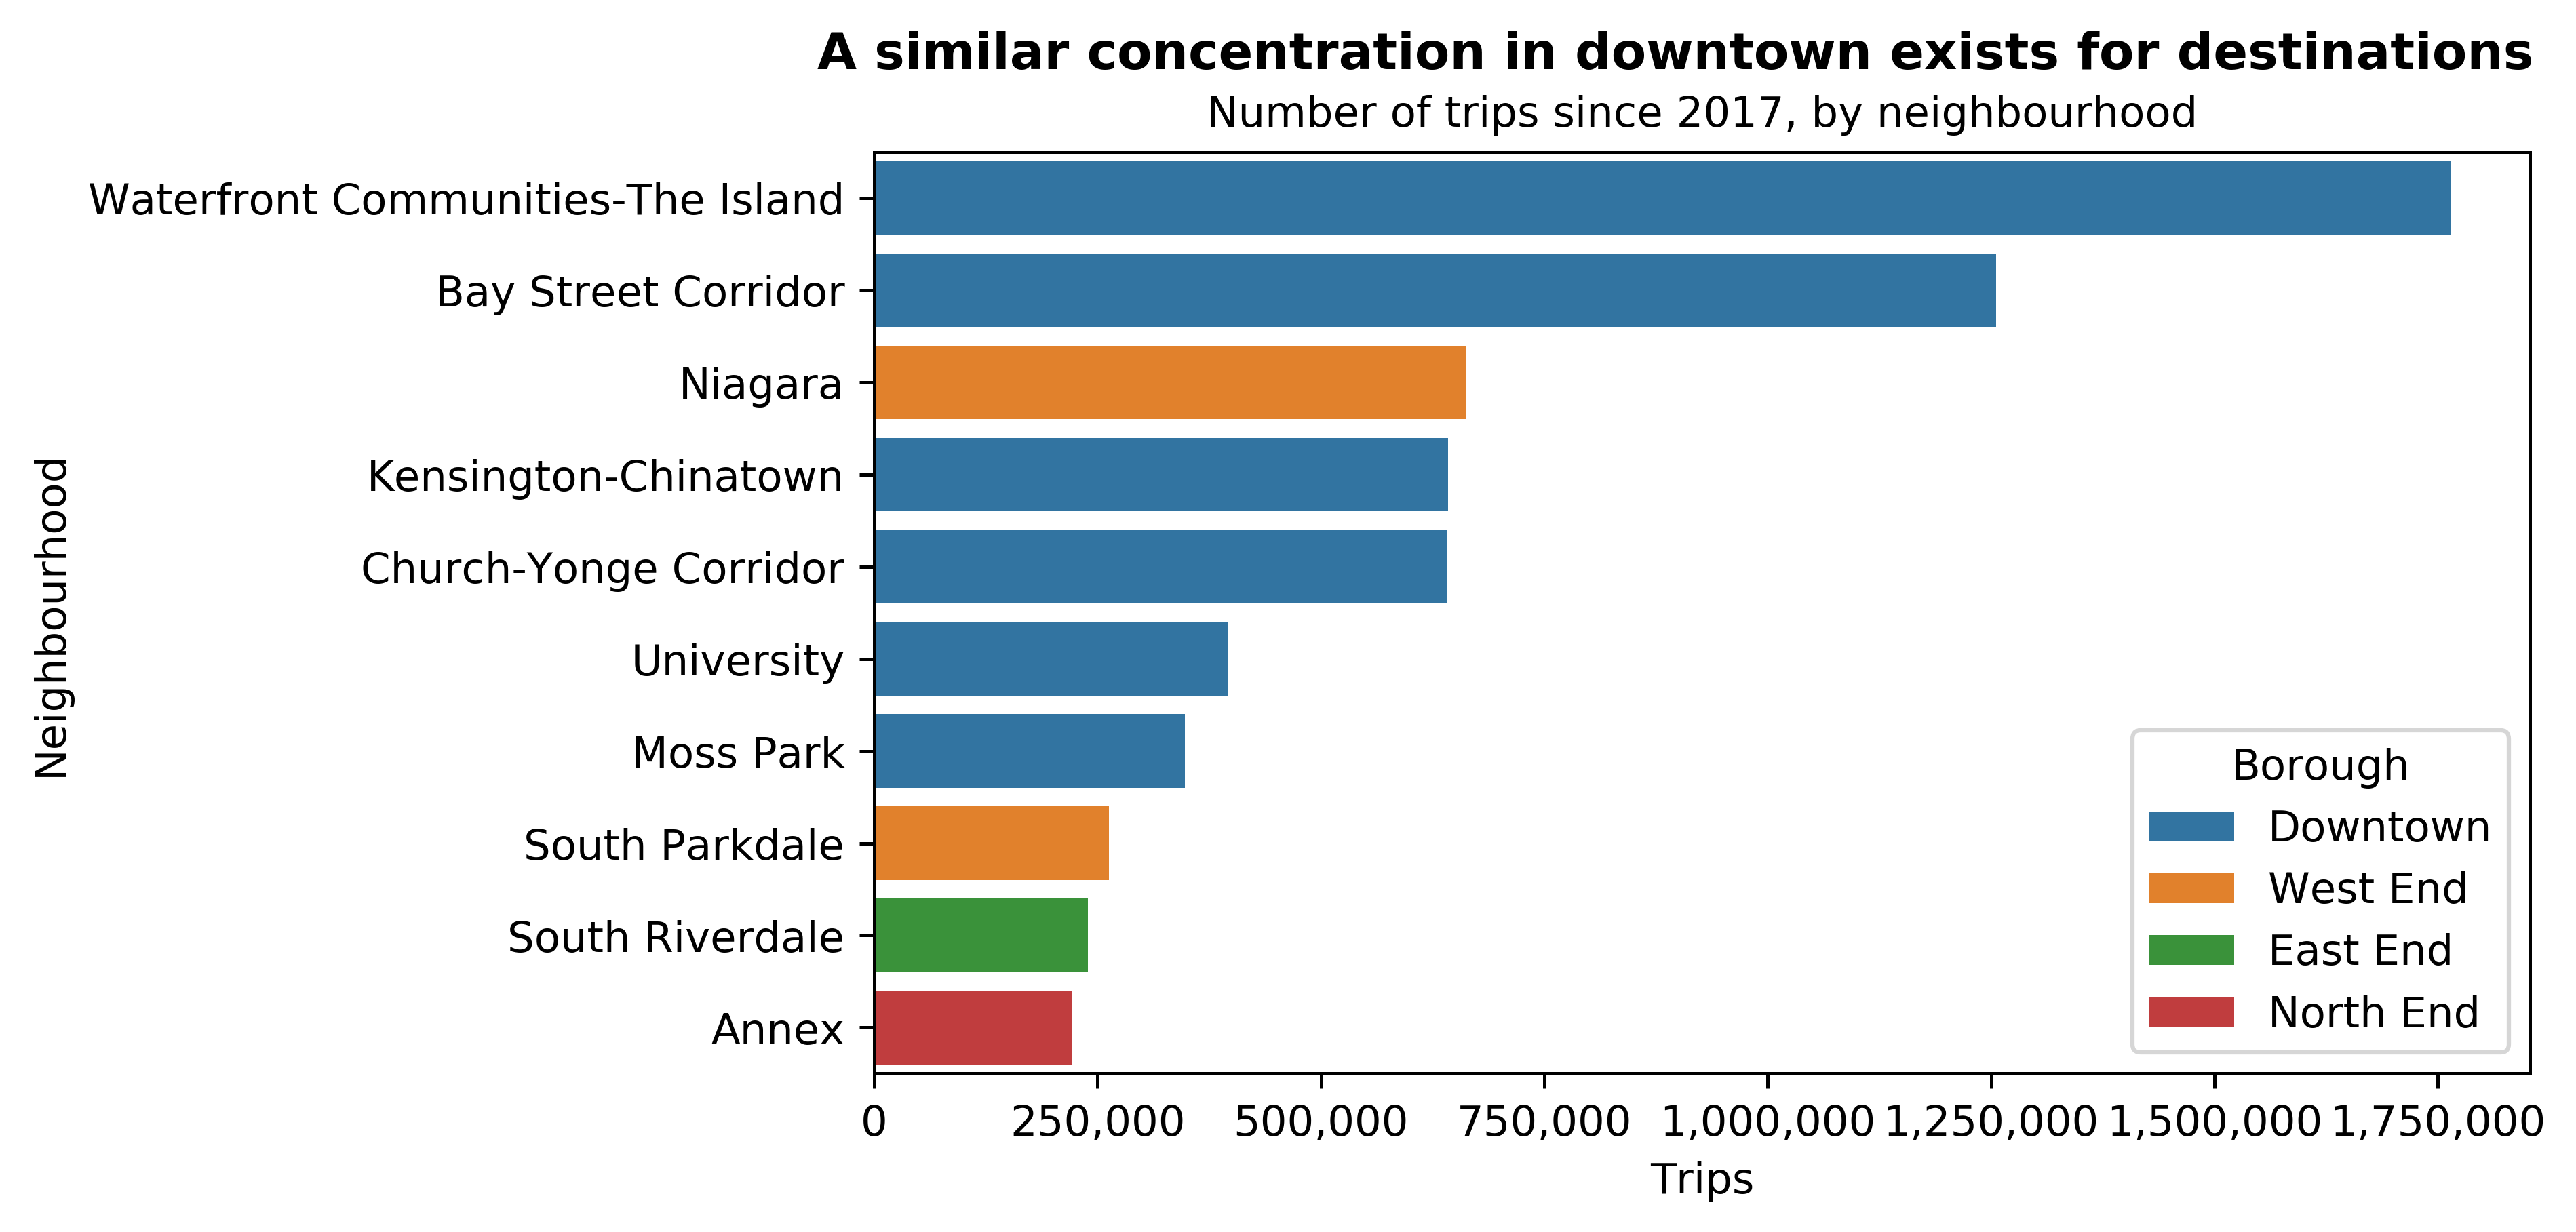

In [28]:
fig, ax = plt.subplots()

fig.set_size_inches(7,4)

top_10_origins = trips_dest_gdf.sort_values(by = 'Trips', ascending = False).head(10)

sns.barplot(y = 'name', x = 'Trips', data = top_10_origins, ax = ax, orient = 'h', hue = 'Borough', dodge = False)

ax.set_yticks(range(10))
ax.set_xticks(range(0,2000000,250000))

ax.set_ylabel('Neighbourhood')
ax.set_xlabel('Trips')

ax.set_title('Number of trips since 2017, by neighbourhood', fontsize = 10)
plt.suptitle('A similar concentration in downtown exists for destinations', fontweight = 'bold', fontsize = 12)

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_yticklabels(top_10_origins['name'])

plt.show()

Now let's to see if there are any imbalances between the origins and destinations. To do this, we'll merge the origin and destination tables together, then get the relative difference of the trips by taking

$ (origins - destinations)/(origins)*100\% $

A negative value would indicate the neighbourhood receives more destinations than origins, while a positive value would indicate more origns than destinations.

In [29]:
trips_neighbourhood = trips_origin_gdf.merge(trips_dest_gdf, on = ['area_short', 'name', 'geometry', 'Borough'], 
                       suffixes = ['_origin', '_destination'])

In [30]:
trips_neighbourhood['delta_perc'] = (trips_neighbourhood['Trips_origin'] - trips_neighbourhood['Trips_destination'])/trips_neighbourhood['Trips_origin']

In [31]:
trips_neighbourhood['delta_perc'].min(), trips_neighbourhood['delta_perc'].max()

(-0.10467111120762666, 0.3214904679376083)

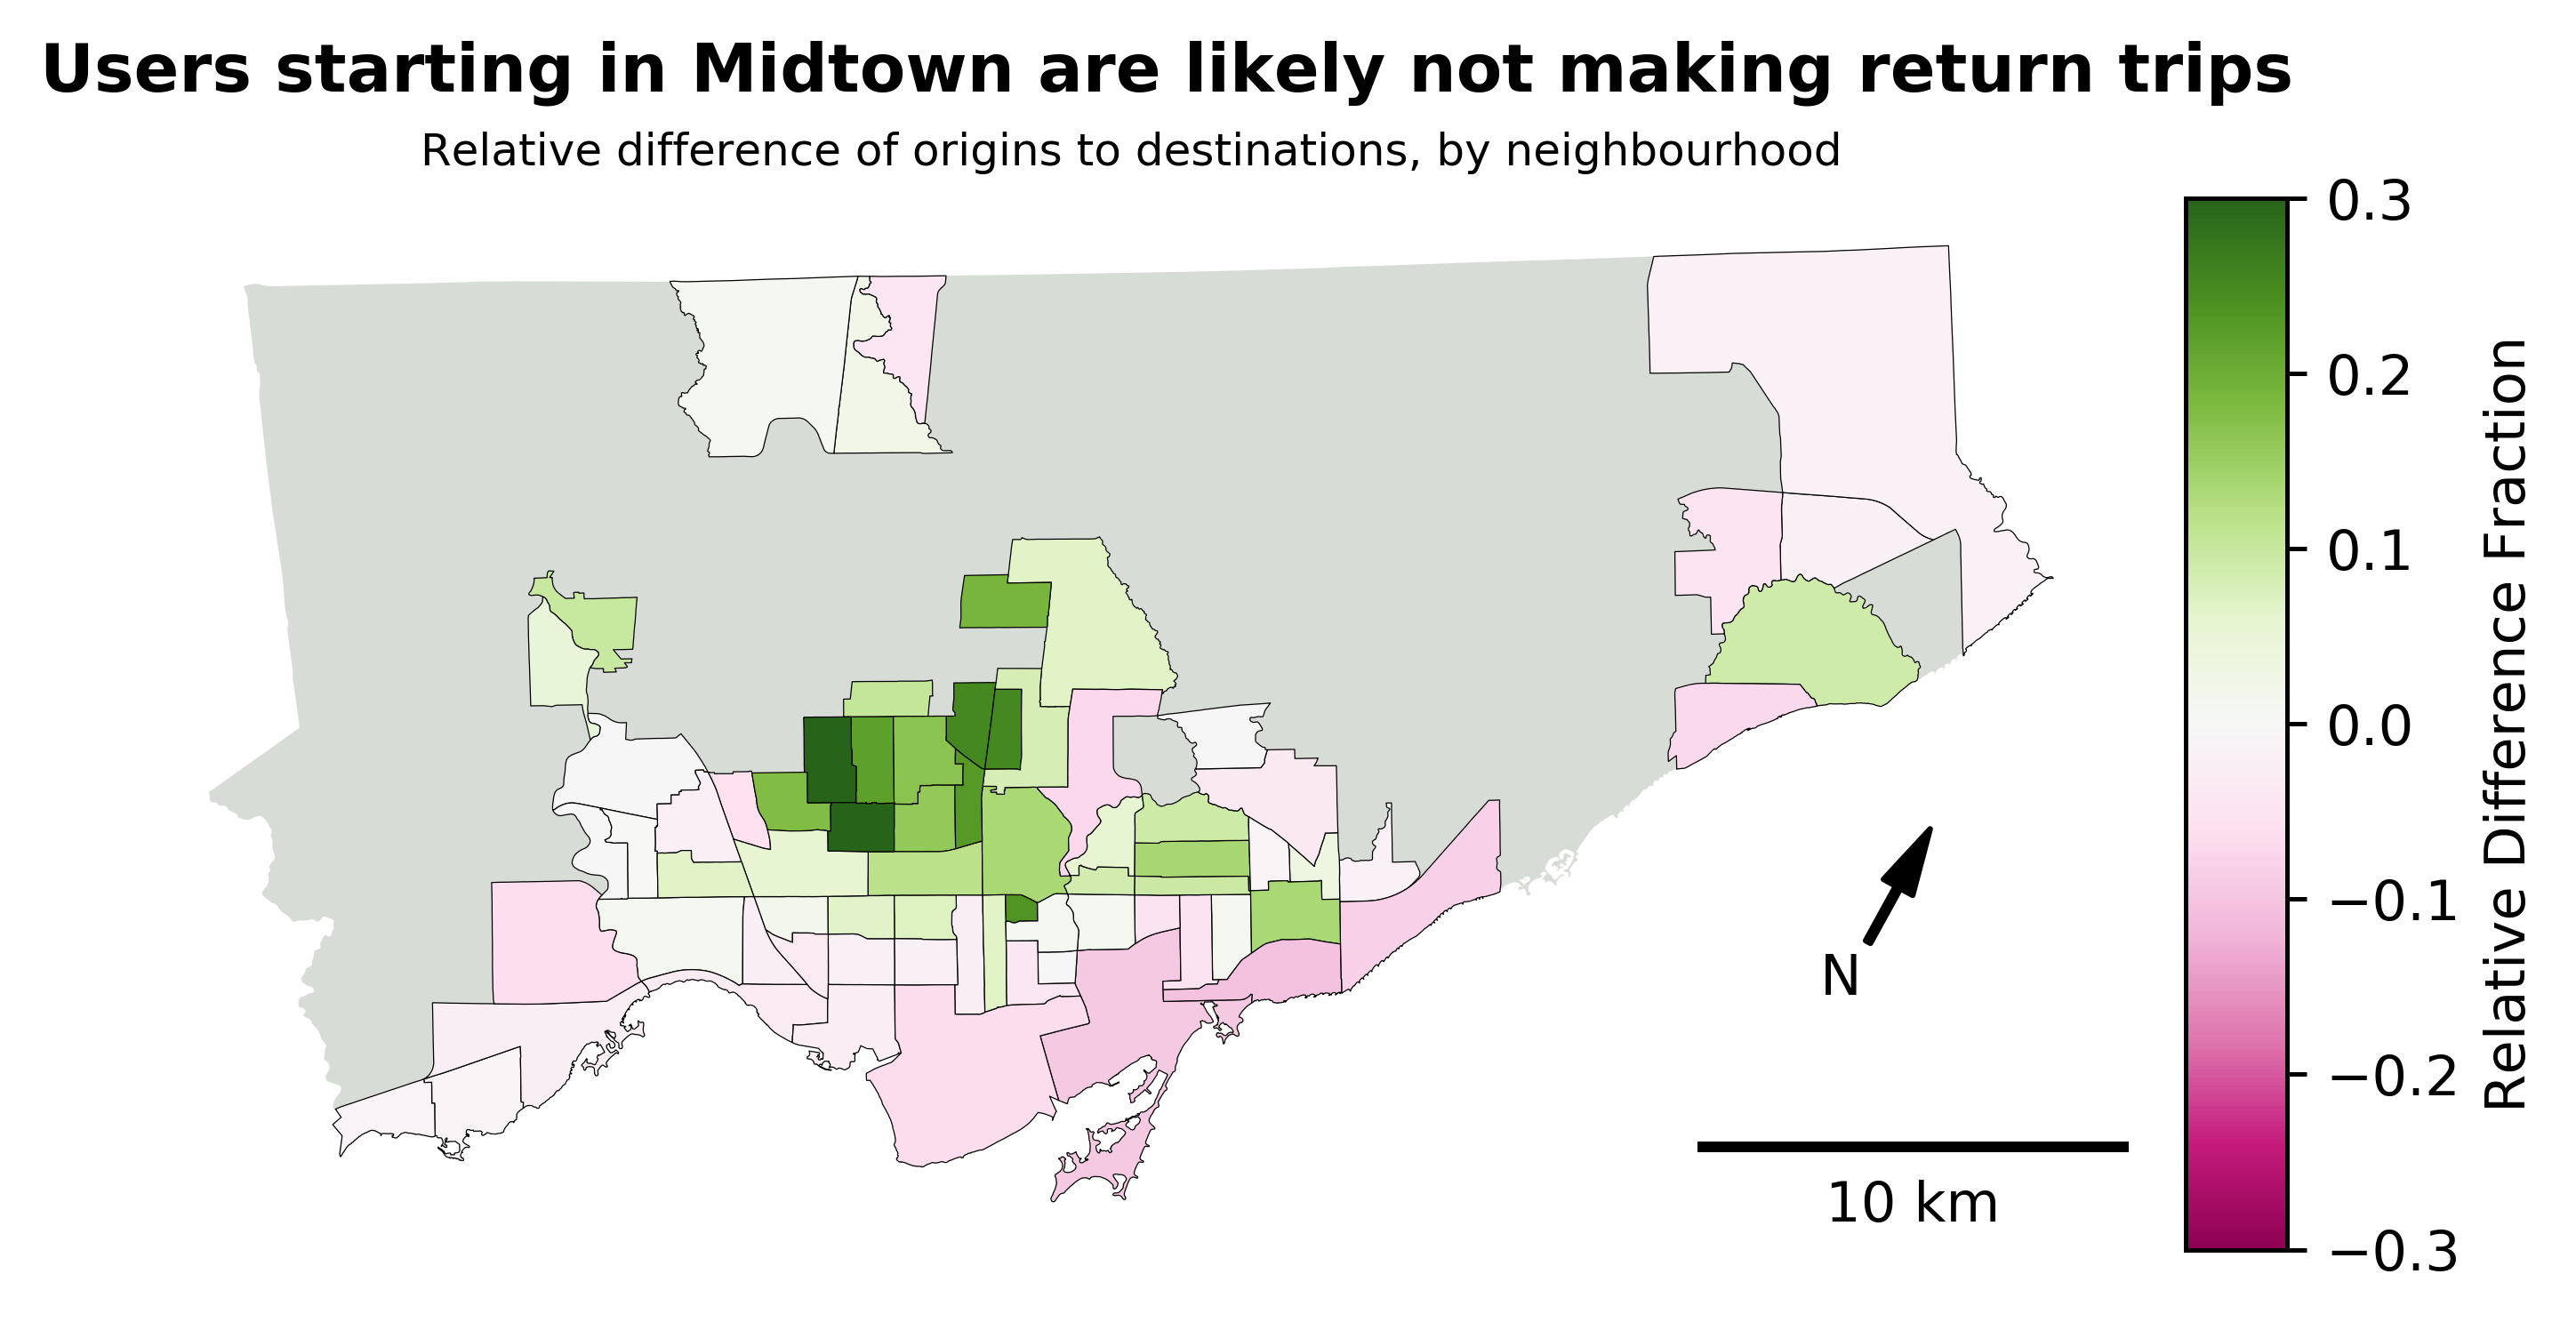

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(7,4)

divider = make_axes_locatable(ax) 

cax = divider.append_axes("right", size="5%", pad=0.1) #to clean up the chloropleth legend

trips_neighbourhood.plot(column = 'delta_perc', cmap = 'PiYG', ax = ax, legend = True, 
                      zorder = 1, edgecolor = 'k', linewidth = 0.2,
                     legend_kwds={'label': "Relative Difference Fraction"}, cax = cax, vmin = -0.3, vmax = 0.3)

city_boundary.plot(ax = ax, zorder = 0, color = 'xkcd:light grey') #any neighbourhood without a bike share trip will be grey

#north arrow
x, y, arrow_length = 0.85, 0.4, 0.15
ax.annotate('N', xy=(x + 0.15 * math.sin(math.radians(17)), y), xytext=(x, y- 0.15 * math.cos(math.radians(17))),
            arrowprops = dict(facecolor='black', width=1, headwidth=6),
            ha='center', va='center', fontsize=10,
            xycoords=ax.transAxes)

plt.suptitle('Users starting in Midtown are likely not making return trips', fontsize = 12, fontweight = 'bold', y = 0.93)

ax.set_title('Relative difference of origins to destinations, by neighbourhood', fontsize = 8)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_axis_off()

ax.add_artist(ScaleBar(1, location = 'lower right', length_fraction = 0.25))# scale bar

From the map, we can see that North End/Midtown neighbourhoods have more origins than destinations. We can probably infer that users starting in the North End are travelling south to downtown, the lakeshore, or the beaches, and do not want to bike back uphill. 

We can see that the topography of the city plays a factor in Bikeshare trips.

## Analyzing Bike Share Flows

Now that we know the origin and destination of Bike Share trips, lets see where they are going. To avoid having a 140x140 matrix, we'll use the borough definitions from earlier. 

Lets merge the trips dataset with `stations_gdf` to assign which borough a trip starts at.

In [33]:
trips_chord = trips_raw.merge(stations_gdf, left_on = 'Start Station Id', right_on = 'Station Id')
trips_chord = trips_chord.rename(columns = {'area_short':'origin_area_short', 'Borough': 'Start Borough'})
trips_chord = trips_chord[['origin_area_short', 'Trip Id', 'End Station Id', 'Start Borough']]

trips_origin_gdf['Trips'] = trips_origin_gdf['Trips'].fillna(0)

We'll also repeat the process for the destinations.

In [34]:
trips_chord = trips_chord.merge(stations_gdf, left_on = 'End Station Id', right_on = 'Station Id')
trips_chord = trips_chord.rename(columns = {'area_short':'dest_area_short', 'Borough': 'End Borough'})
trips_chord = trips_chord[['Trip Id', 'Start Borough',  'End Borough']]
trips_chord.head()

,Trip Id,Start Borough,End Borough
0,712441,Downtown,Downtown
1,717862,Downtown,Downtown
2,719500,Downtown,Downtown
3,722310,Downtown,Downtown
4,723078,Downtown,Downtown


Now let's perform a groupby action, using `count()` as the aggregation method. 

In [35]:
trips_chord = trips_chord.groupby(['Start Borough', 'End Borough']).count()

In [36]:
trips_chord = trips_chord.reset_index()

In [37]:
trips_chord = trips_chord.rename(columns = {'Trip Id': 'Trips'})

To convert to an origin-destination matrix, we'll use `pivot` function found in pandas. 

Traditionally in transportation, origins are represented by rows, while destinations are columns.

In [38]:
trips_matrix = trips_chord.pivot(index = 'Start Borough', columns = 'End Borough', values = 'Trips').fillna(0)
trips_matrix

End Borough,Downtown,East End,East York,Etobicoke,North End,North York,Scarborough,West End,York
Start Borough,,,,,,,,,
Downtown,4238228.0,212746.0,9488.0,2087.0,202108.0,13.0,25264.0,666509.0,180.0
East End,194954.0,198633.0,13396.0,0.0,11285.0,47.0,2960.0,7227.0,2.0
East York,11756.0,13832.0,12461.0,0.0,3096.0,1234.0,248.0,184.0,1.0
Etobicoke,2294.0,1.0,0.0,34119.0,3.0,0.0,3.0,49291.0,958.0
North End,256020.0,11515.0,3369.0,4.0,142728.0,362.0,216.0,72214.0,1219.0
North York,17.0,18.0,1432.0,0.0,282.0,10955.0,1.0,0.0,4.0
Scarborough,22911.0,3573.0,228.0,4.0,113.0,27.0,5345.0,2690.0,0.0
West End,674135.0,7698.0,107.0,51523.0,51185.0,0.0,3312.0,791293.0,2756.0
York,526.0,3.0,3.0,963.0,1379.0,1.0,0.0,3026.0,1323.0


To make a chord diagram, we'll need to install a package that uses matplotlib to easily make chord diagrams. 

As an inital visualizers, chord diagrams can convey the flow a lot easier than a heatmap, which needs annotations to be useful, and may be overwhelming for non-technical audiences. 

In [39]:
!pip install mpl-chord-diagram

In [40]:
from mpl_chord_diagram import chord_diagram

In [41]:
#manually defining names so that certain boroughs are on 2 lines.

names = ['Downtown', 'East\nEnd', 'East\nYork', 'Etobicoke', 'North\nEnd',
       'North\nYork', 'Scarborough', 'West\nEnd', 'York'] 

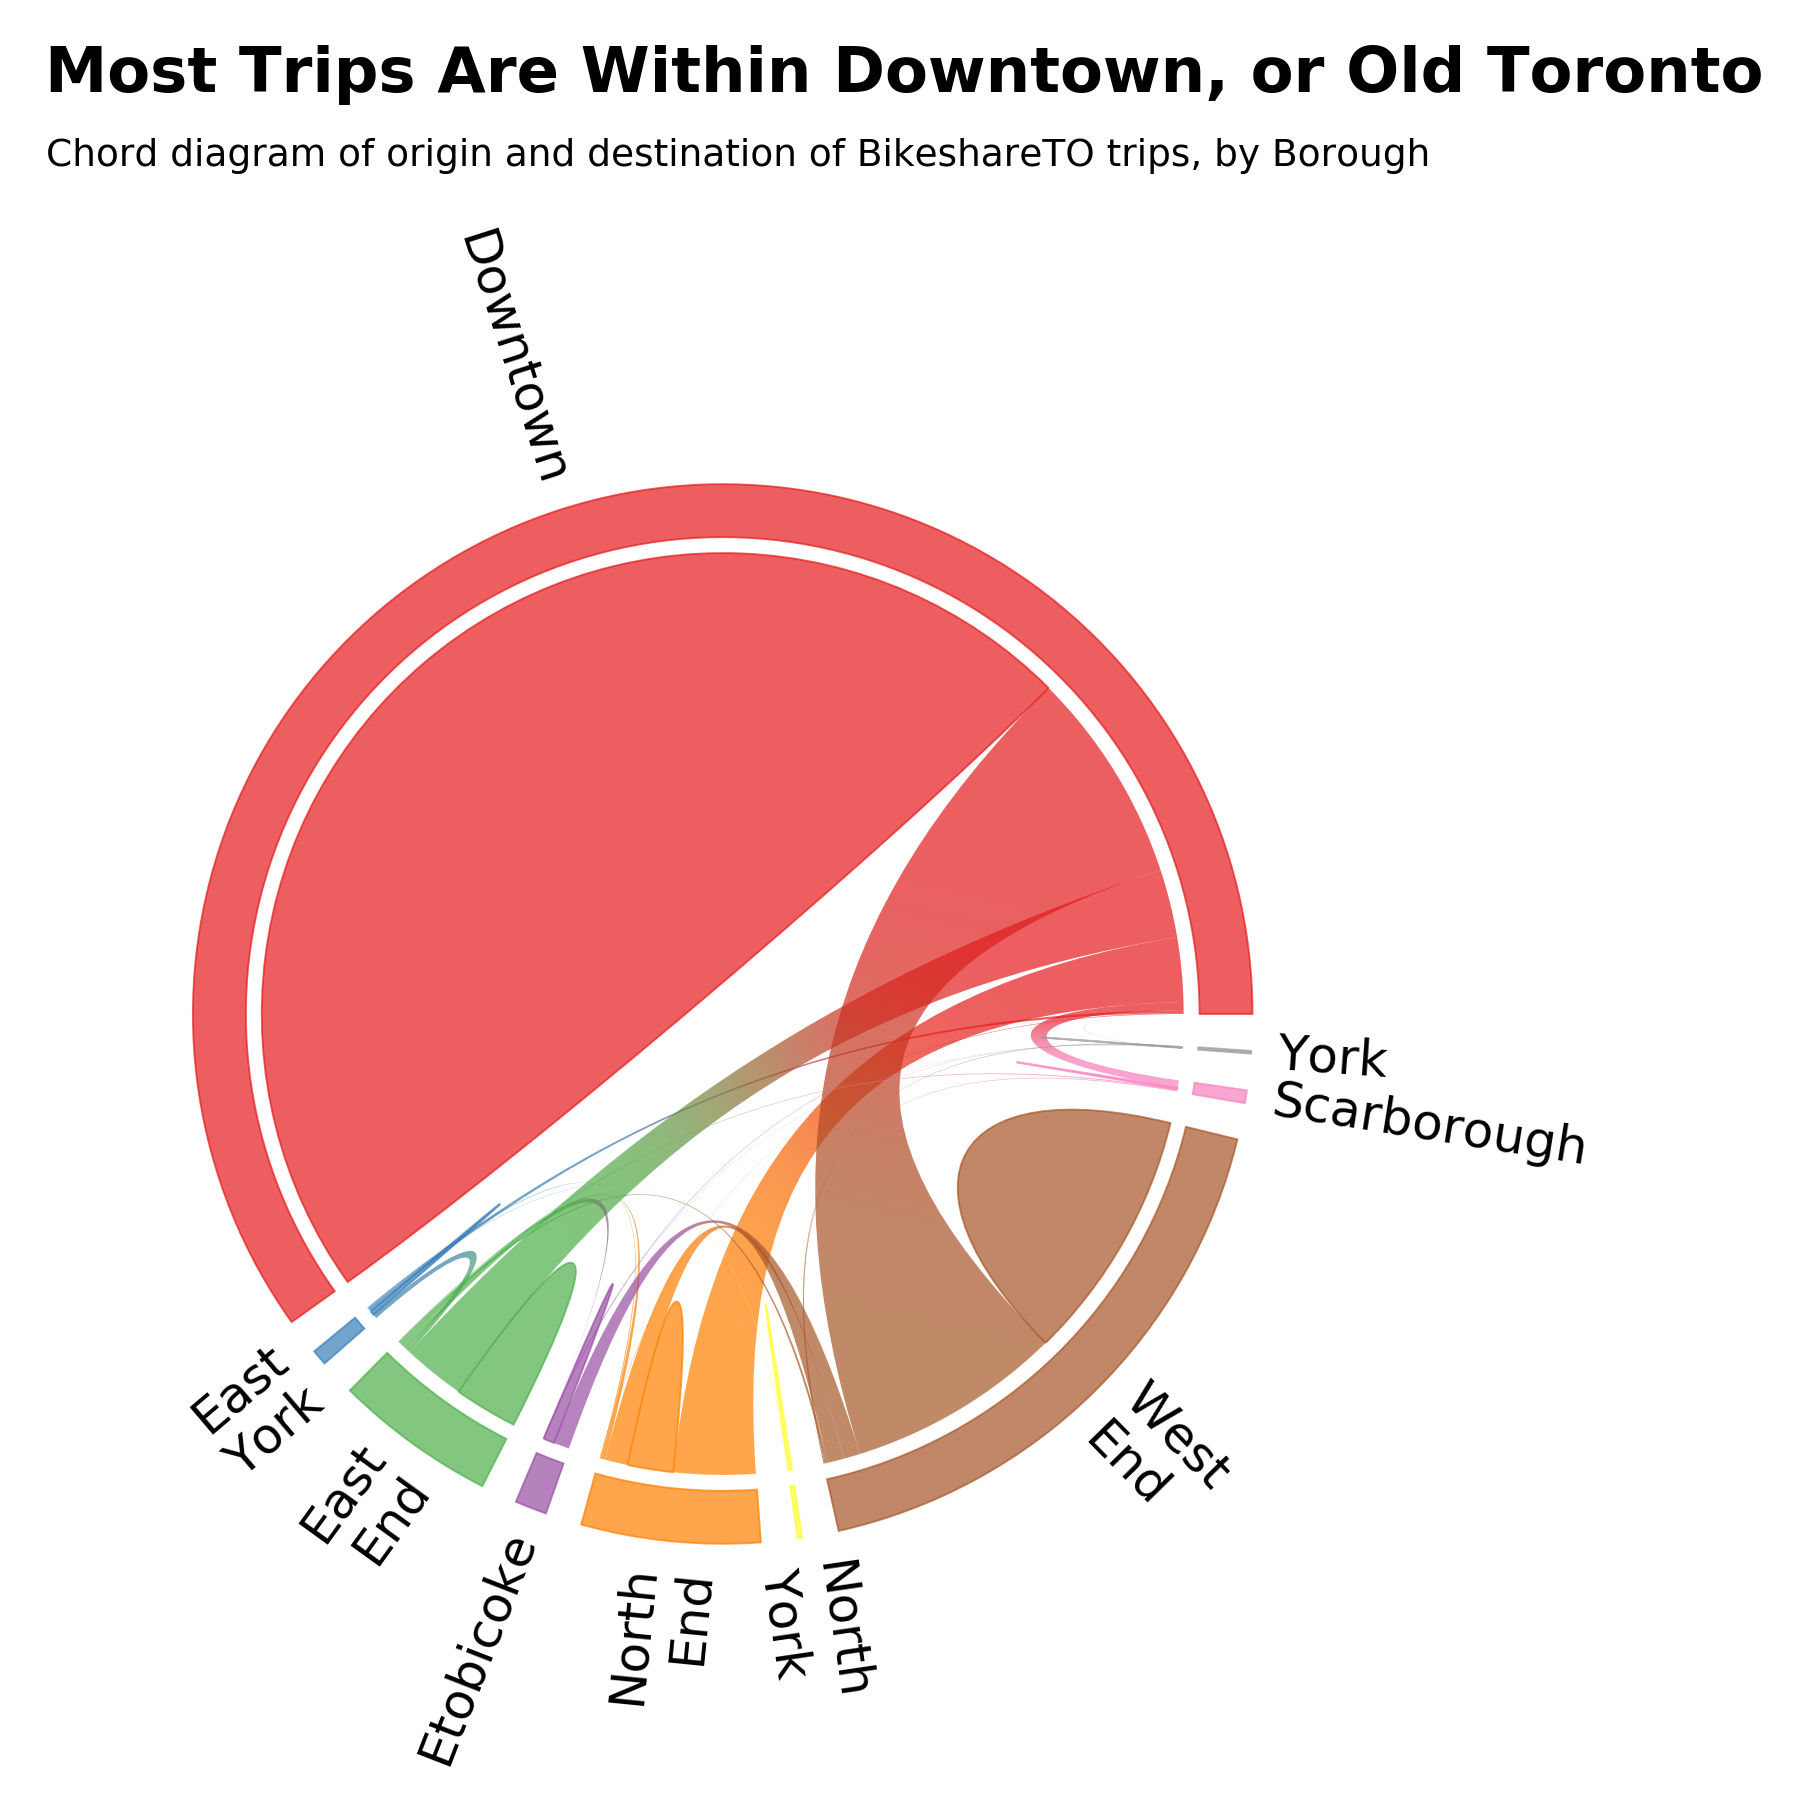

In [42]:
fig, ax = plt.subplots()

plt.suptitle('Most Trips Are Within Downtown, or Old Toronto', x = 0.249, y = 0.99, ha = 'left', fontsize = 10, fontweight = 'bold')
ax.text(s = 'Chord diagram of origin and destination of BikeshareTO trips, by Borough', x = 0.03, y = 1.6, ha = 'center', fontsize = 6)

chord = chord_diagram(trips_matrix, names = names, cmap = 'Set1', ax = ax, fontsize = 8, rotate_names = 90,
                      order = [0,2,1,3,4,5,7,6,8], pad = 4, use_gradient =  True)

Here, we can easily see that Downtown to Downtown trips make up close to half of the trips. The other Old Toronto boroughs have a significant amount trips, and roughly half of their trips go to/come from downtown. Inter-borough trips are also a significant source of trips for all boroughs.

Of the remaining boroughs, Etobicoke (again likely due to the Martin Goodman Trail) looks to be the busiest, while York and North York are among the bottom for trips. This is likely because Scarborough has signifcant activity.

Another way to visualize the flow between regions of Toronto is to make a heat map. We'll convert the data in the matrix to ratios/percentages, and then uses `sns.heatmap` to make the graph.

In [43]:
order = ['Downtown',  'West End', 'East End', 'North End', 'East York', 'Etobicoke',
       'North York', 'Scarborough', 'York']

In [44]:
trips_matrix = trips_matrix.reindex(index=order, columns=order)

In [45]:
trips_matrix_perc = trips_matrix/trips_matrix.sum().sum()

Text(0, -0.25, 'Heatmap representation of BikeShare Toronto origin-destination matrix, by borough')

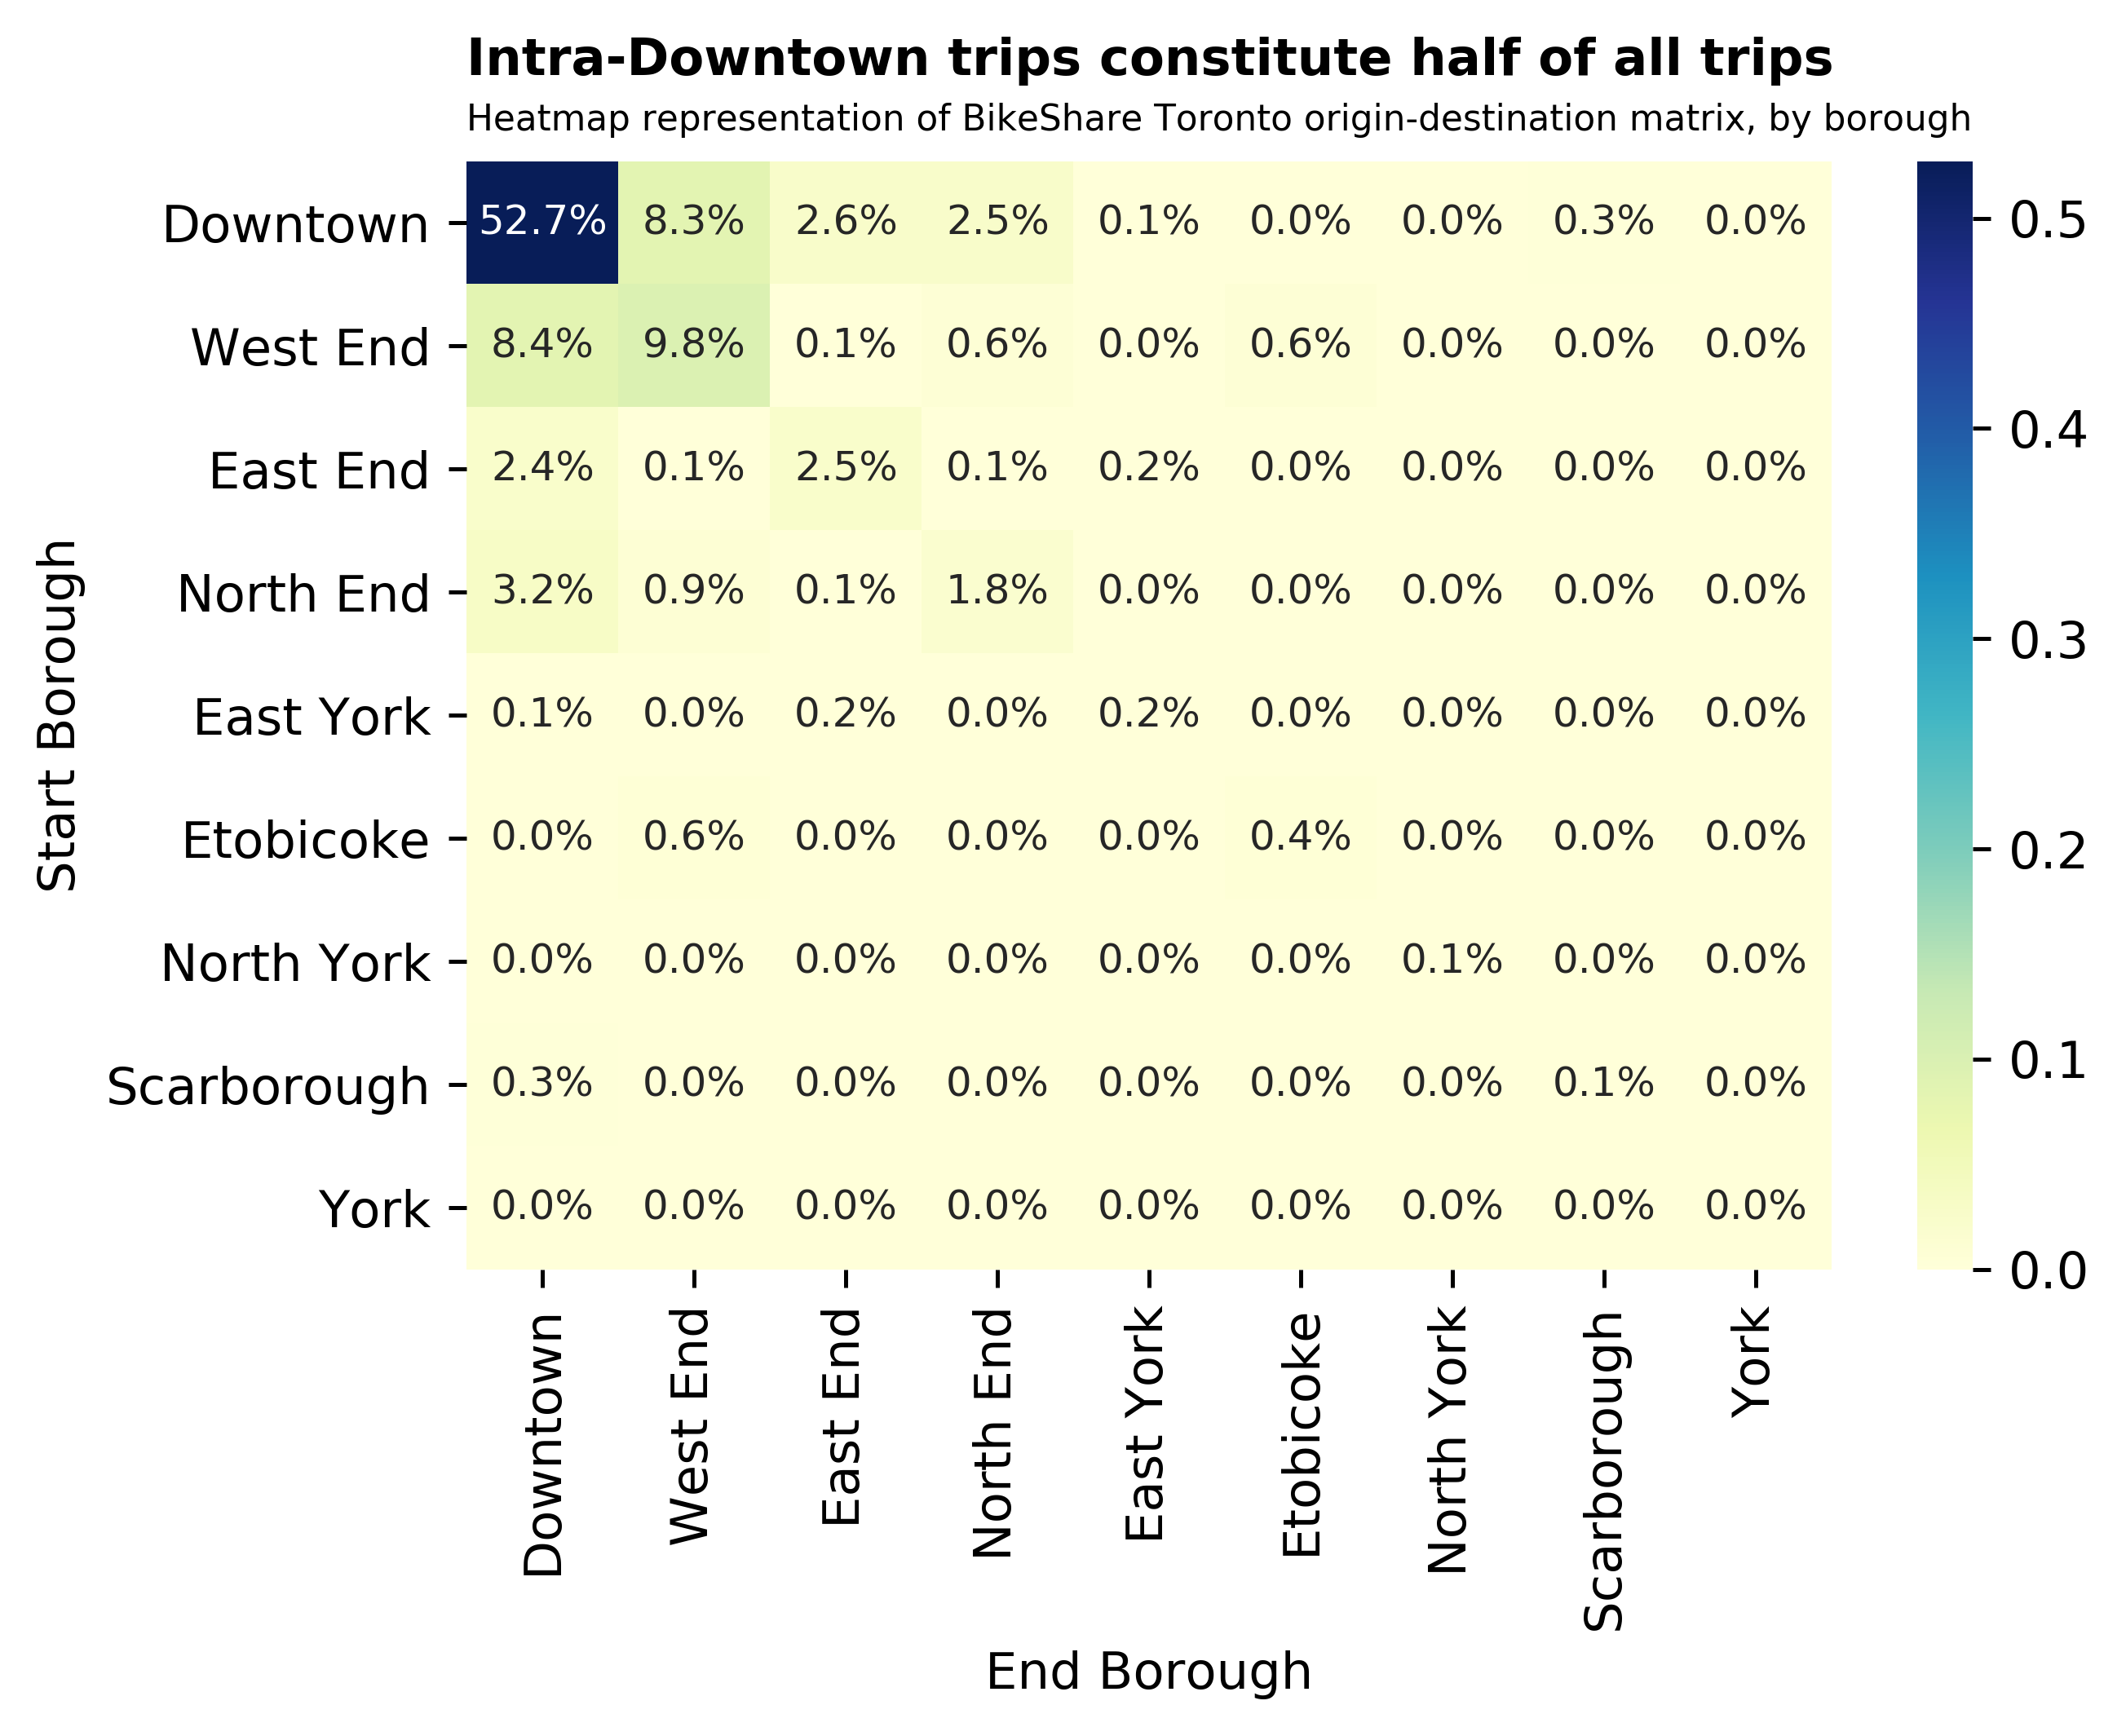

In [88]:
ax = sns.heatmap(trips_matrix_perc, fmt = '.1%', annot = True, cmap="YlGnBu", annot_kws={"fontsize":8})

ax.text(s = 'Intra-Downtown trips constitute half of all trips', fontweight = 'bold', y = -0.70, x = 0, ha = 'left')
ax.text(s = 'Heatmap representation of BikeShare Toronto origin-destination matrix, by borough', fontsize = 7, y = -0.25, x = 0, ha = 'left')

The advantage of the heat map is that we can clearly see the numeric values that the chord diagram represents. Downtown clearly dominates the number of trips, so in order to visualize the data in other boroughs, we'll take out intra-downtown trips, recalculate the ratios, and make a new heatmap.

In [77]:
trips_matrix_mod = trips_matrix
trips_matrix_mod.iloc[0,0] = None

In [78]:
trips_matrix_perc_mod = trips_matrix_mod/trips_matrix_mod.sum().sum()

Text(0, -0.25, 'Heatmap representation of BikeShare Toronto origin-destination matrix, by borough')

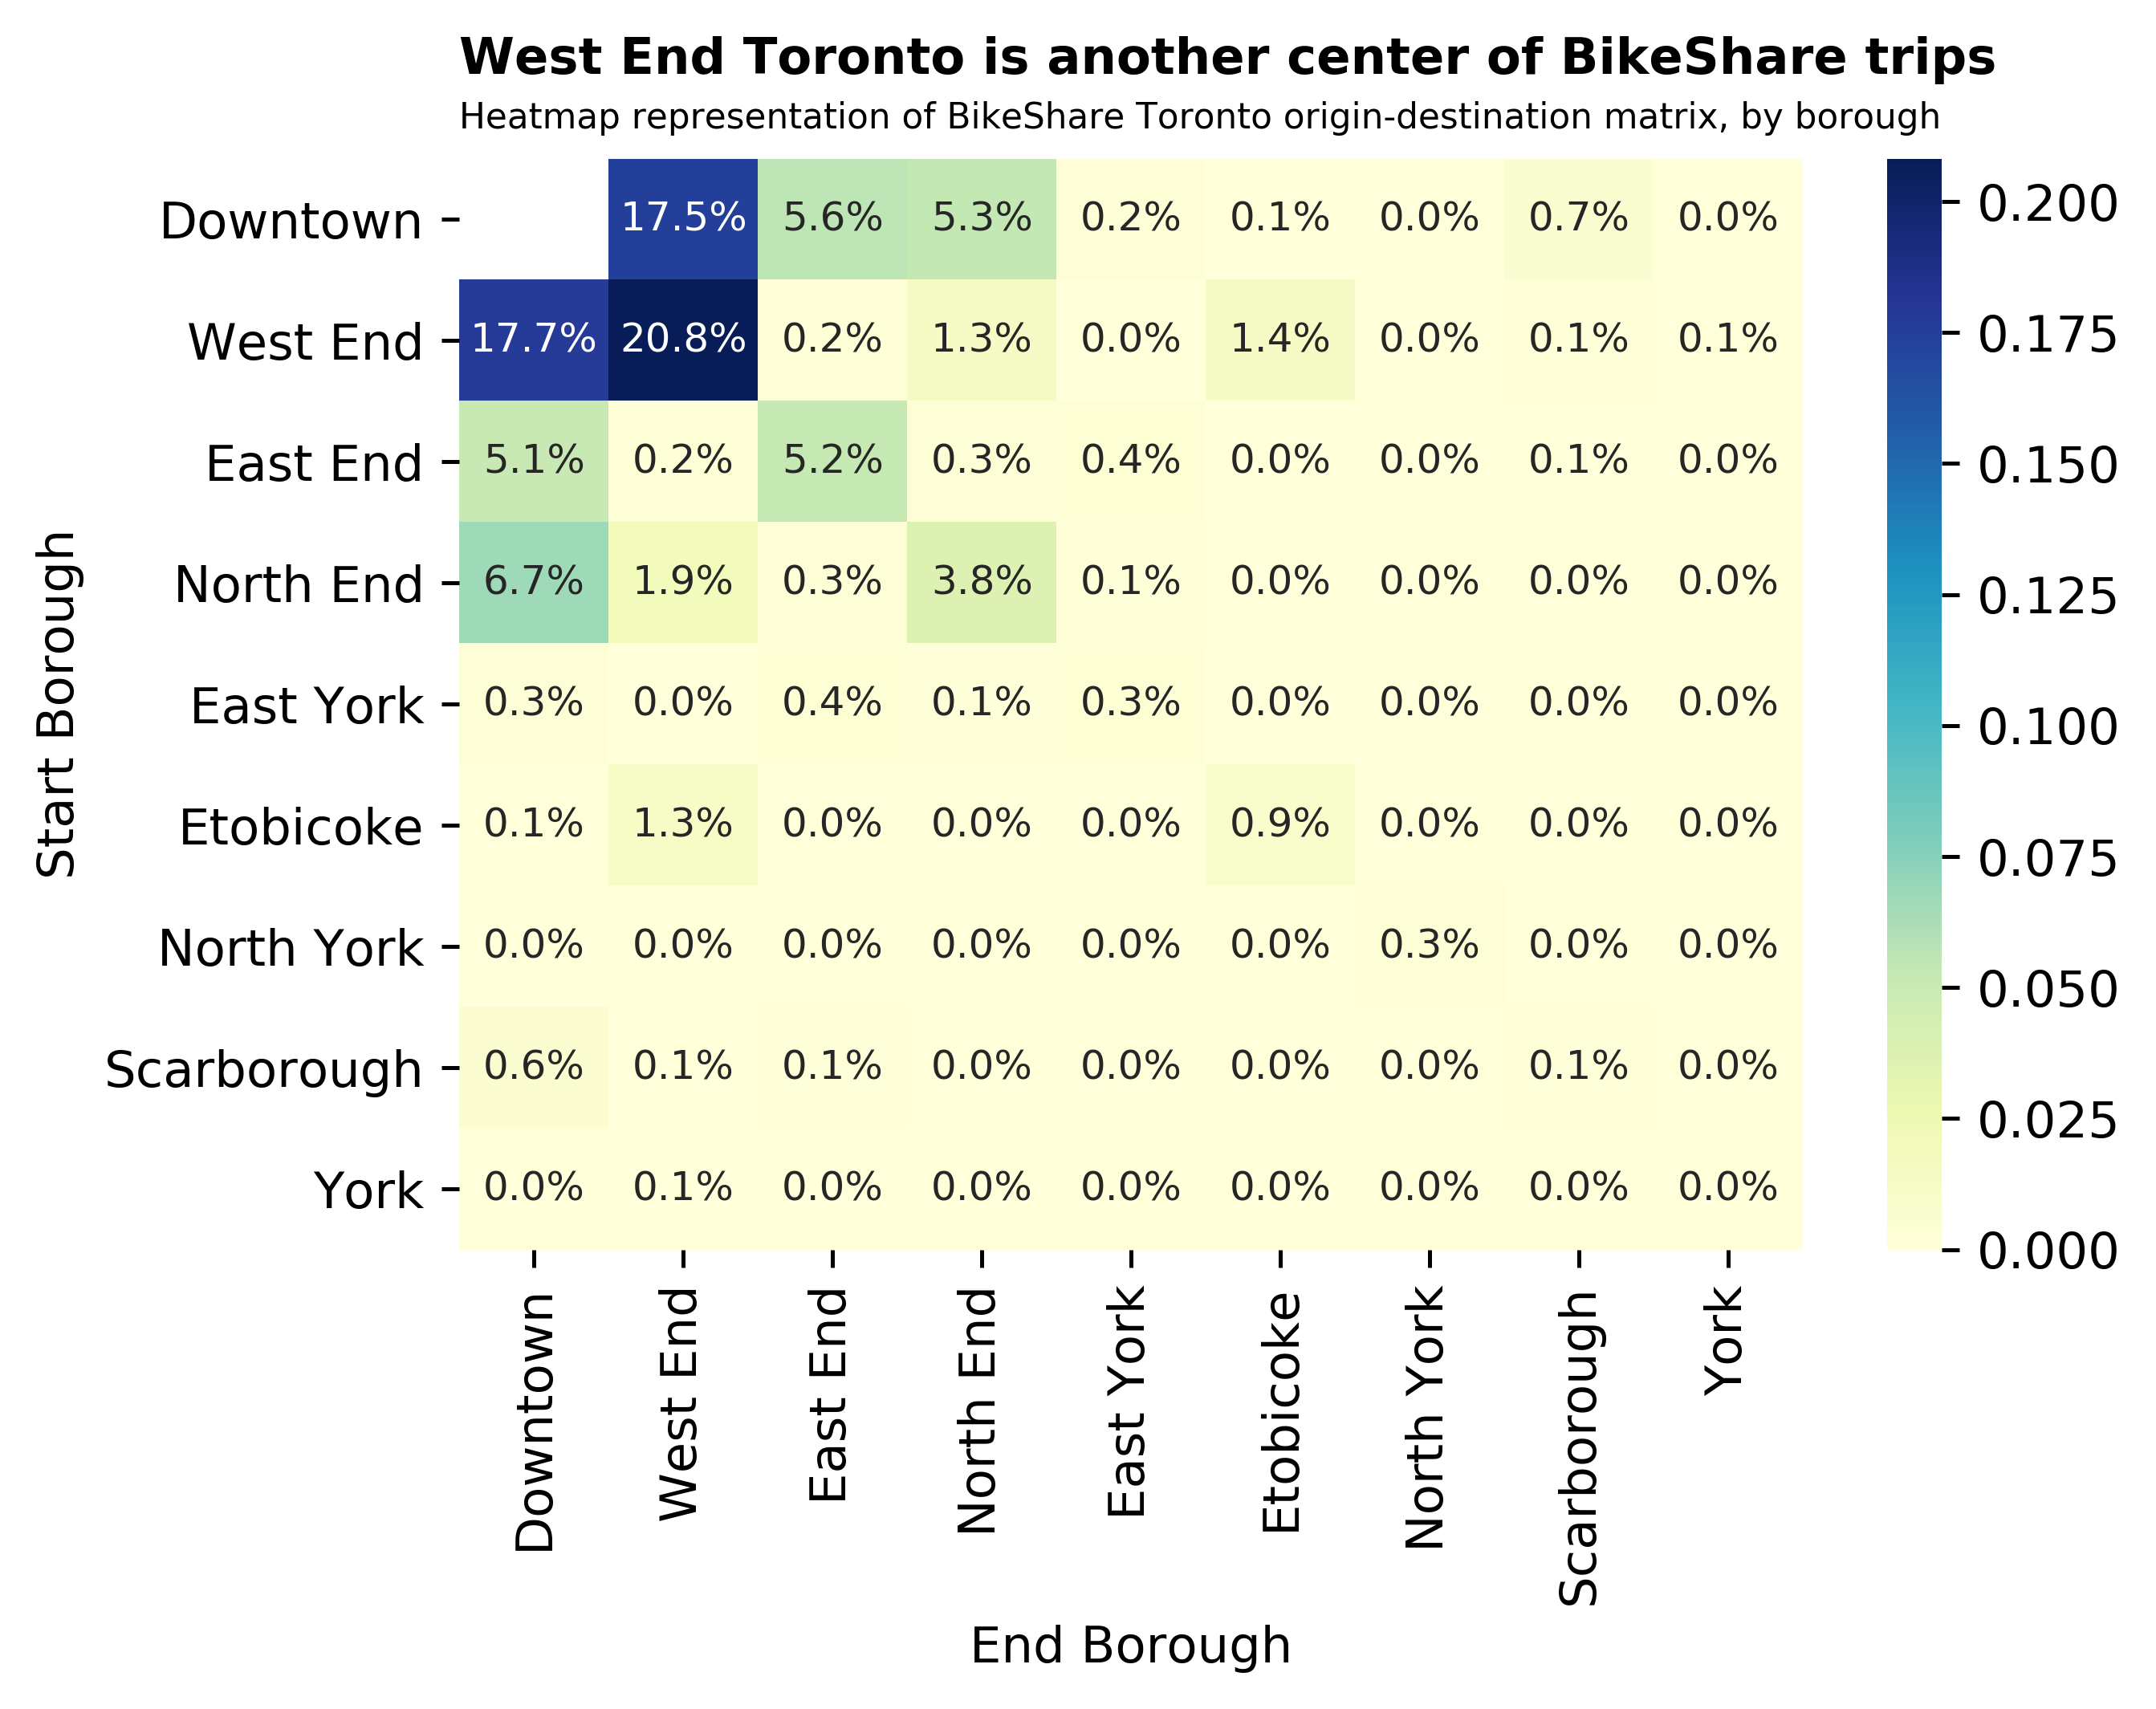

In [89]:
ax = sns.heatmap(trips_matrix_perc_mod, fmt = '.1%', annot = True, cmap="YlGnBu", annot_kws={"fontsize":8})

ax.text(s = 'West End Toronto is another center of BikeShare trips', fontweight = 'bold', y = -0.70, x = 0, ha = 'left')
ax.text(s = 'Heatmap representation of BikeShare Toronto origin-destination matrix, by borough', fontsize = 7, y = -0.25, x = 0, ha = 'left')

Similar to the chord diagram, we see that trips in Old Toronto capture the rest of the BikeShare trips, and there is very limited activity in the suburbs. Of the Old Toronto neighbourhoods, West End neighbourhoods has the highest activity, which could be influenced by the Martin Goodman trail, the presence of the Bloor Bike Lane, and generally more bikelane infrastructure in the West End.